In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from datetime import datetime
import optuna
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from optuna.samplers import TPESampler
import sqlalchemy
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, mean_squared_error,mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier
from optuna.samplers import TPESampler
from sklearn.linear_model import Ridge  # 使用 Ridge 回归代替逻辑回归
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
from scipy.stats import entropy
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示问题
import sys
print(sys.executable)

C:\Users\Acer\anaconda3\envs\transformer_git\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\Acer\anaconda3\envs\transformer_git\python.exe


In [2]:
df = pd.read_csv('F:\Graduate materials\论文\代码\output_vectorized_sequences.csv')

In [3]:
df = df.drop(columns = ['商品名称',  '关联店铺', '商品分类', '商品品牌', '浏览量', '视频数','抖音号'])
df['佣金率'] =df['佣金率'].str.replace('%', '').astype(float) / 100
df = df.dropna()
df.sort_values(by='佣金率')

佣金率  带货视频   带货直播       粉丝数  商品价格最小值  商品价格最大值  销售均价最小值  销售均价最大值  \
0      0.00  82.0  163.0   2520591      289      649    300.0    400.0   
10661  0.00   0.0   34.0  10466187       69       69     50.0    100.0   
10662  0.00   0.0   19.0  10466187     1391     1399   1200.0   1400.0   
10663  0.00   0.0   17.0  10466187      199      199    100.0    200.0   
10664  0.00   0.0   40.0  10466187       44       49     10.0     50.0   
...     ...   ...    ...       ...      ...      ...      ...      ...   
22033  0.40   0.0    4.0   9124893      199     1596    100.0    200.0   
9188   0.45   0.0    1.0    585017        5        5      0.0      0.0   
17395  0.50   0.0    3.0    571766       99      318     50.0    100.0   
9147   0.50   0.0   11.0    585017       68       68      0.0      0.0   
15514  0.50   0.0    3.0   4140519        1        1      0.0     10.0   

       销售额_编码  销量_编码  ...  转化率_编码  上架距今(天)       视频热度            点赞  \
0          21     12  ...       1      647   6.143400     15.563333   
10661       6      1  ...       1      360   5.735067     33.406667   
10662       6      1  ...       1      203   5.735067     33.406667   
10663       6      1  ...       1      144   5.735067     33.406667   
10664       6      2  ...       1     1304   5.735067     33.406667   
...       ...    ...  ...     ...      ...        ...           ...   
22033       8      1  ...       1      308  14.985782  13272.109005   
9188        0      0  ...       3      273  10.286700    537.780000   
17395      16     10  ...       4      317  22.799116   5984.514056   
9147        0      0  ...       1      611  10.286700    537.780000   
15514       2      2  ...       2      327   9.271333    453.570000   

                评论          分享          收藏           互动量       互动率  \
0         1.383333    4.143333    4.083333     25.173333  0.002402   
10661     3.790000    2.116667    2.303333     41.616667  0.003288   
10662     3.790000    2.116667    2.303333     41.616667  0.003288   
10663     3.790000    2.116667    2.303333     41.616667  0.003288   
10664     3.790000    2.116667    2.303333     41.616667  0.003288   
...            ...         ...         ...           ...       ...   
22033  1169.933649  641.113744  488.199052  15571.355450  0.015064   
9188     37.143333   85.856667   74.980000    735.760000  0.002305   
17395   562.614458  110.012048  219.353414   6876.493976  0.020884   
9147     37.143333   85.856667   74.980000    735.760000  0.002305   
15514    15.273333   28.606667   40.103333    537.553333  0.007996   

       cluster_label  
0                  0  
10661              0  
10662              0  
10663              0  
10664              0  
...              ...  
22033              1  
9188               0  
17395              0  
9147               0  
15514              0  

[23615 rows x 24 columns]

In [4]:
def choose(x):
    if x >= 3:
        return 3 
    else:
        return x

df['转化率_1'] = df['转化率_编码'].apply(lambda x: choose(x))

print(df['转化率_1'].value_counts())

df = df.drop(columns=['转化率_编码'])

转化率_1
1    13330
2     5362
3     3294
0     1629
Name: count, dtype: int64


In [5]:
# 分离特征和目标变量

df['销售均价最大差值'] = df['销售均价最大值'] - df['销售均价最小值']
df['销售均价'] = (df['销售均价最大值'] + df['销售均价最小值']) /2

df['商品价格最大差值'] = df['商品价格最大值'] - df['商品价格最小值']
df['商品价格中位数'] = (df['商品价格最大值'] + df['商品价格最小值']) /2

df = df.drop(columns=['销售均价最大值','销售均价最小值','商品价格最大值','商品价格最小值'])

# X = df.drop(columns=['转化率_编码','转化率_1'])
X = df.drop(columns=['转化率_1'])
y = df['转化率_1']
# 拆分训练集和测试集（70%训练，30%测试）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print(X_train.shape)

(20072, 23)


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
df_scaled = X_scaled.copy()
df_scaled['转化率_1'] = df['转化率_1']
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

## 相关性分析

In [8]:
corr_matrix = X.corr()
plt.figure(figsize=(12,5))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.gcf().set_facecolor('gray')  
plt.title('Correlation Matrix')
save_path = f'../EDA/Correlation Matrix'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Correlation Matrix 图像已保存至 {save_path}")
plt.show()

Correlation Matrix 图像已保存至 ../EDA/Correlation Matrix


## 特征分布

In [9]:
# def plot_distribution(data,y,feature):
#     plt.figure(figsize=(12, 6))
#     for yi in data[y].unique():
#         sns.histplot(data[data[y] == yi][feature],kde=True,stat='count', label=f'{y}: {yi}')
#     plt.legend(title = y,bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.ylim(0, 1500) 
#     plt.show()    

# plot_distribution(data_scaled,'转化率_1','粉丝数')

def plot_distribution(df,target,y_name, log_transform=False, trim_outliers=False):
    plt.figure(figsize=(12,6))
    plt.subplot(111)
    for yi in [0,1,2,3]:
        class_yi = df[df[y_name] == yi][target]
        
        # 如果需要对数变换
        if log_transform:
            class_yi = np.log1p(class_yi)  # 对数变换（避免零值的问题）
        
        # 如果需要截断极值
        if trim_outliers:
            lower = np.percentile(class_yi, 1)
            upper = np.percentile(class_yi, 99)
            class_yi = class_yi[(class_yi >= lower) & (class_yi <= upper)]
        
        
        max_val = class_yi.max()
        min_val = class_yi.min()
        range_val = max_val - min_val
        
        if range_val == 0:
            print(f"Warning: {target} for y = {yi} has no variance, skipping.")
            continue
        
        bin_size = range_val / 20
        num_bins_train = num_bins_test = round(range_val / bin_size)
        
        mean_yi = np.mean(class_yi)
        median_yi = np.median(class_yi)
        
        plt.hist(class_yi,  density=True, alpha=0.5, label=f'y = {yi} Histogram',bins=num_bins_test)
        
        # 计算正态分布概率密度函数
        x_values_yi = np.linspace(class_yi.min(), class_yi.max(), len(class_yi))
        density_values_yi = (1 / (np.sqrt(2 * np.pi) * np.std(class_yi))) * np.exp(-0.5 * ((x_values_yi - mean_yi) / np.std(class_yi))**2)
        plt.plot(x_values_yi, density_values_yi, linewidth=2,color = plt.cm.Set1(yi),label= f'y = {yi} Density')
        
        # plt.axvline(mean_yi, linestyle='dashed', linewidth=2, label=f'Mean y = {yi}')
        
        

    plt.xlabel(target)
    plt.ylabel('Frequency / Density')
    plt.legend(bbox_to_anchor=(1,1),fancybox=False,shadow=False, loc='upper left')
    pre_name = 'Log Transformed'* log_transform
    name = f'{pre_name} Histograms and Density Plots for {target}'
    plt.title(name,fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.7)
    save_path = f'../EDA/{name}'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Correlation Matrix 图像已保存至 {save_path}")
    plt.show()    


Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 佣金率


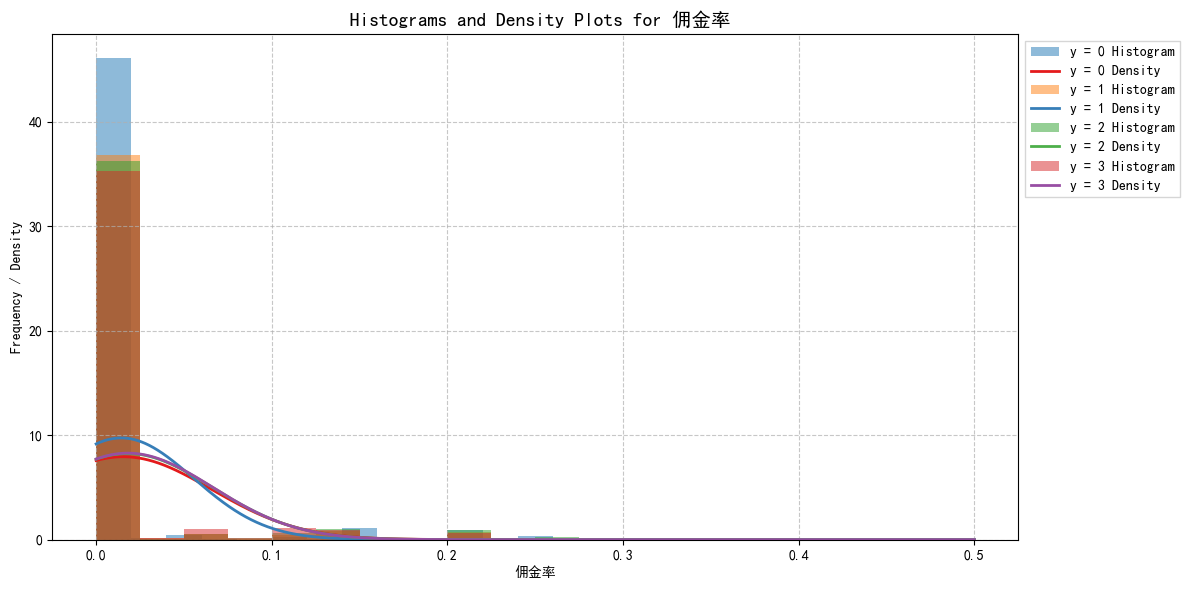

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 带货视频


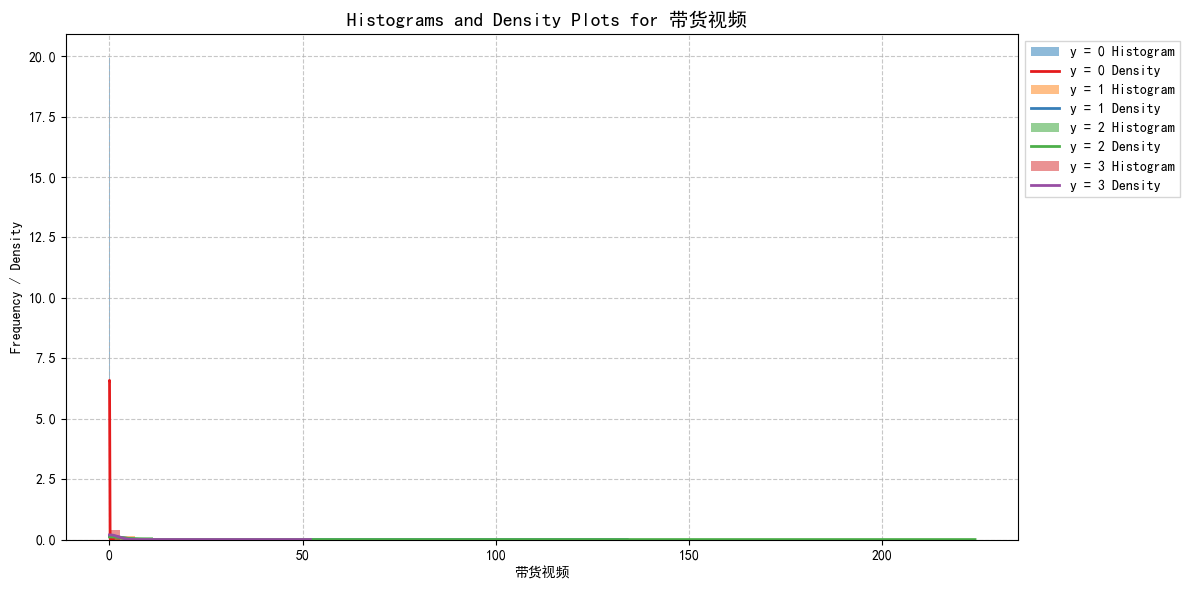

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 带货直播


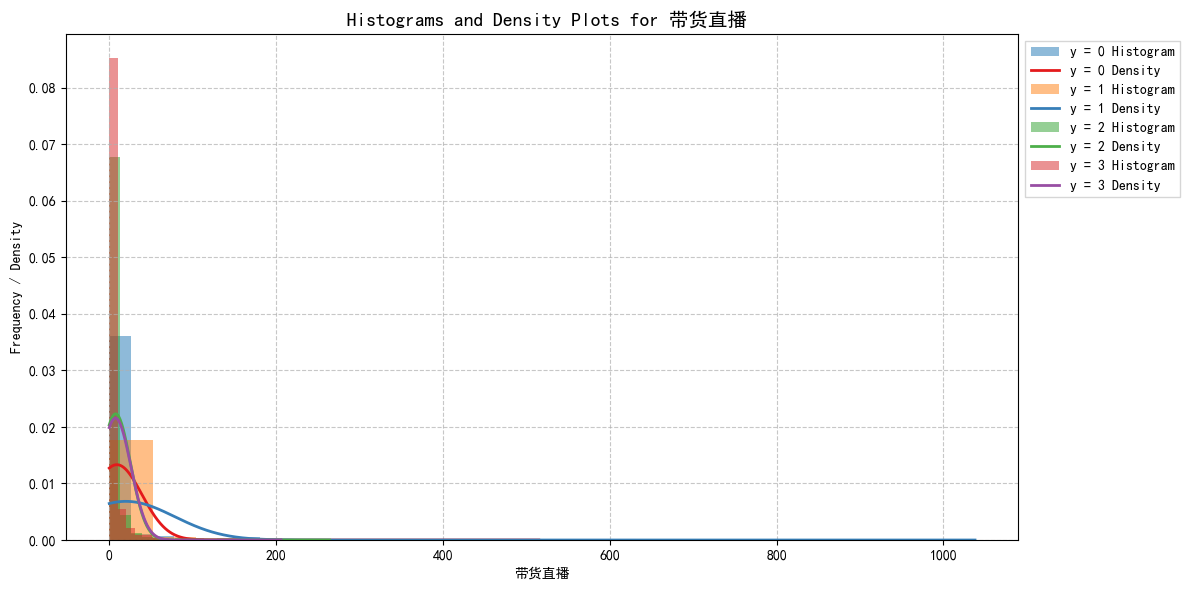

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 粉丝数


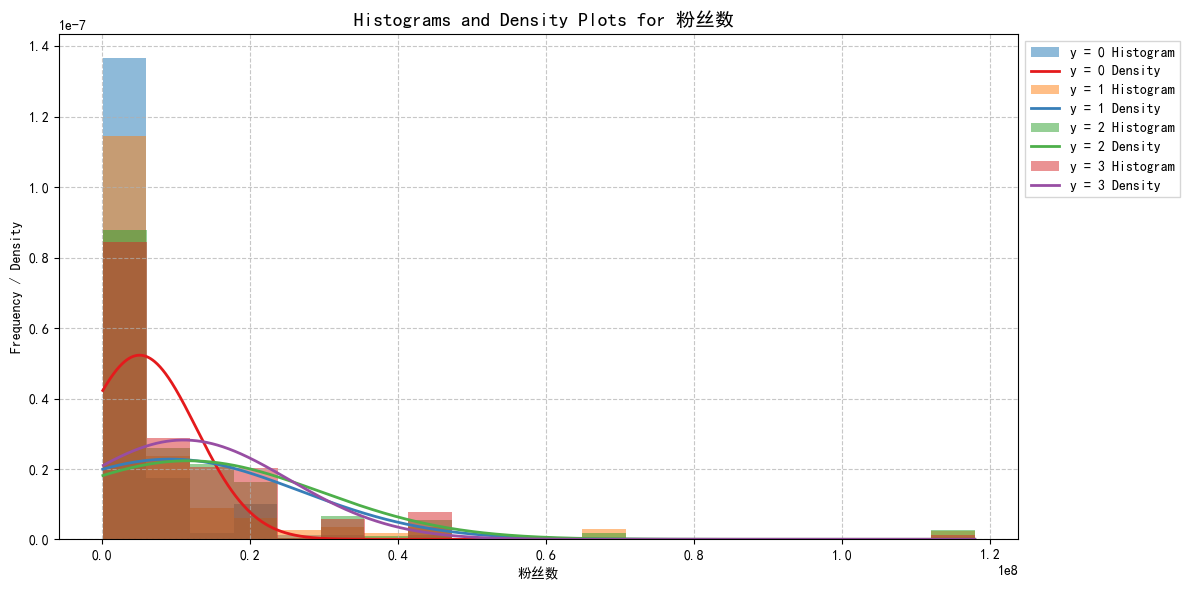

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 销售额_编码


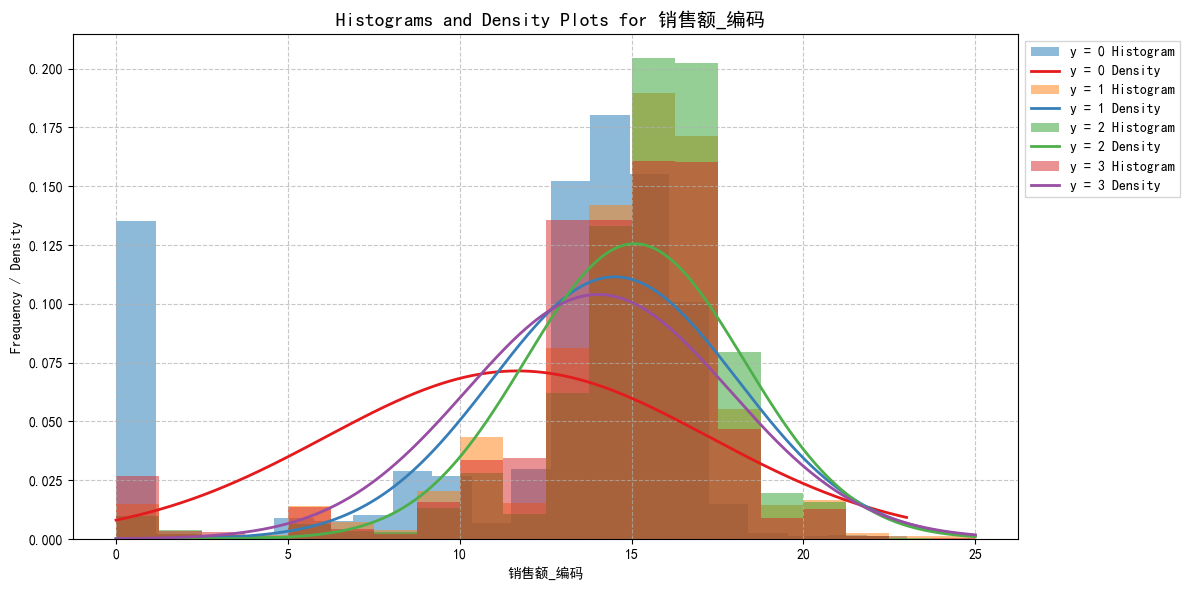

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 销量_编码


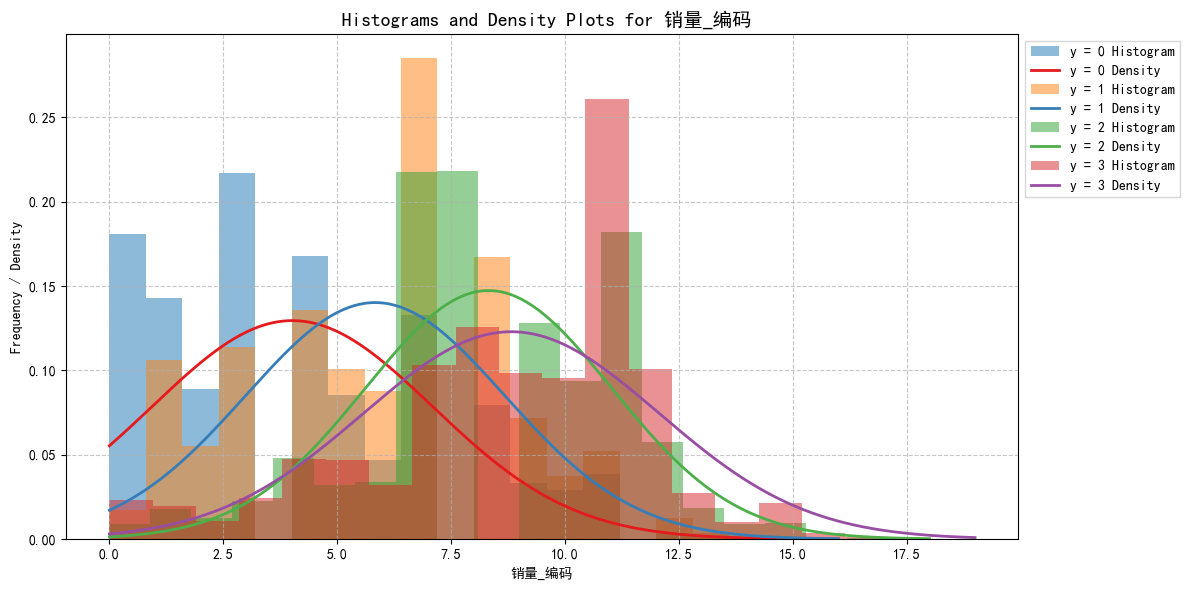

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 视频销售额_编码


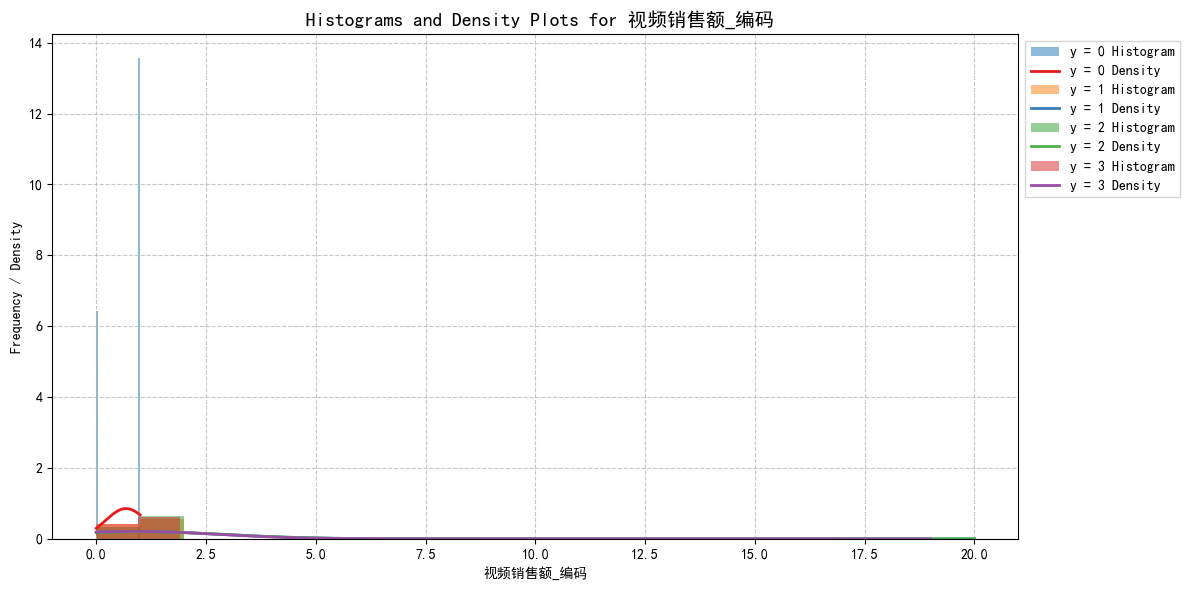

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 视频销量_编码


Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 直播销售额_编码


Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 直播销量_编码


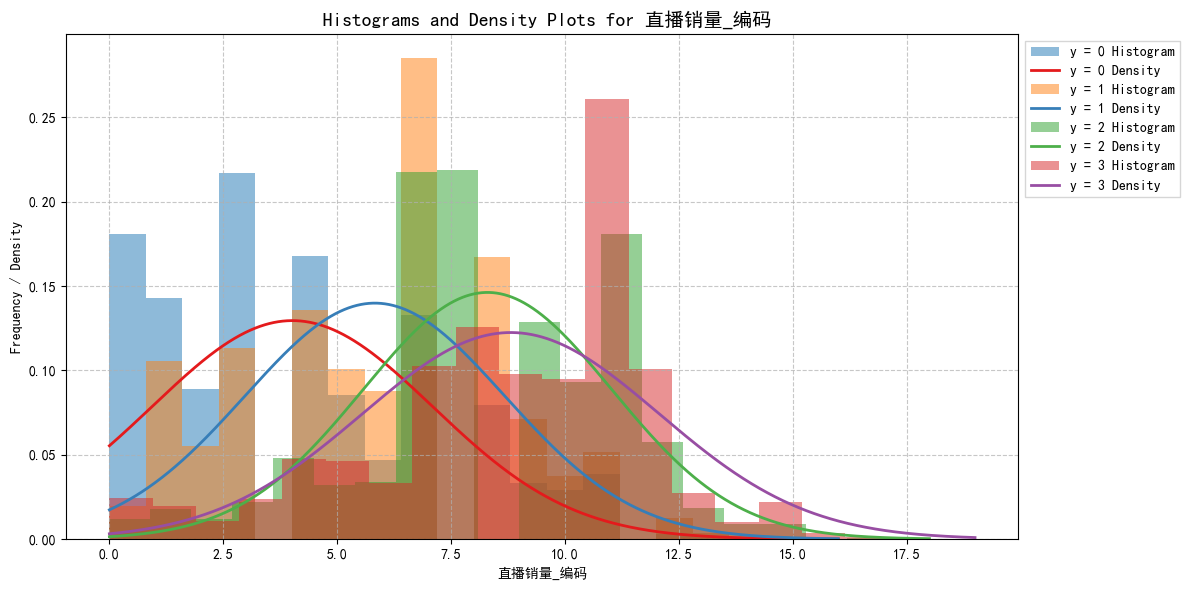

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 上架距今(天)


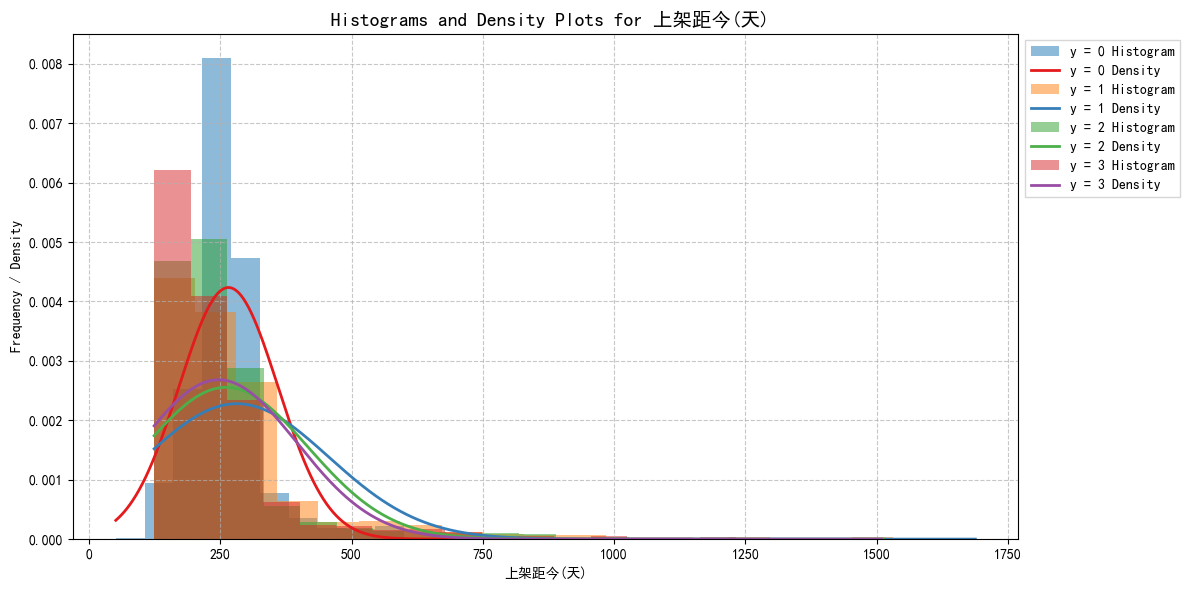

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 视频热度


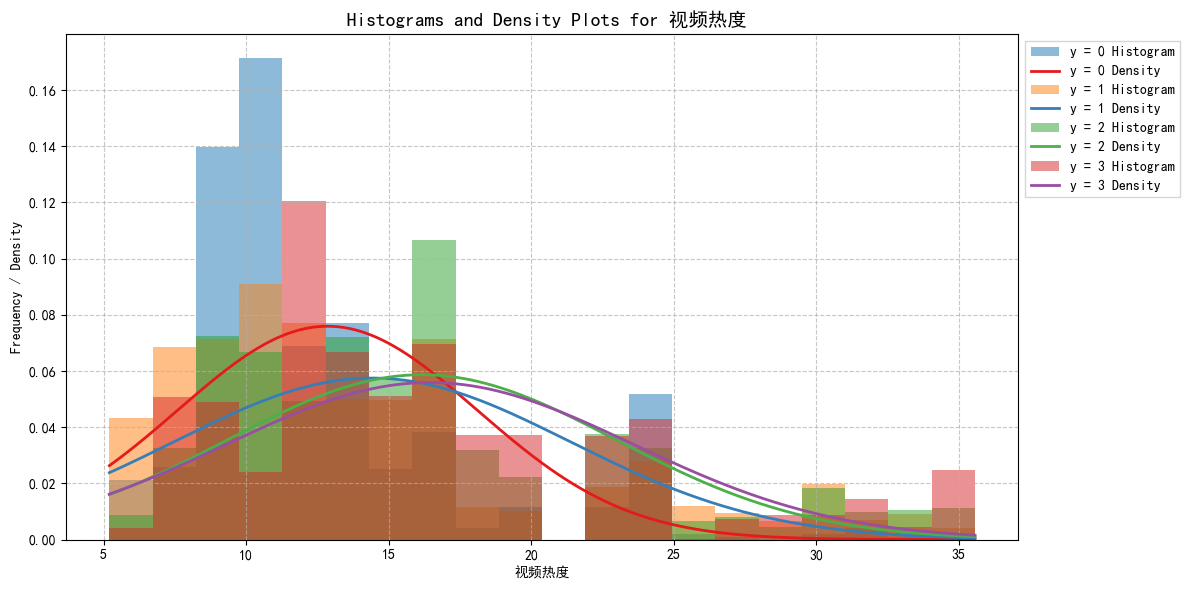

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 点赞


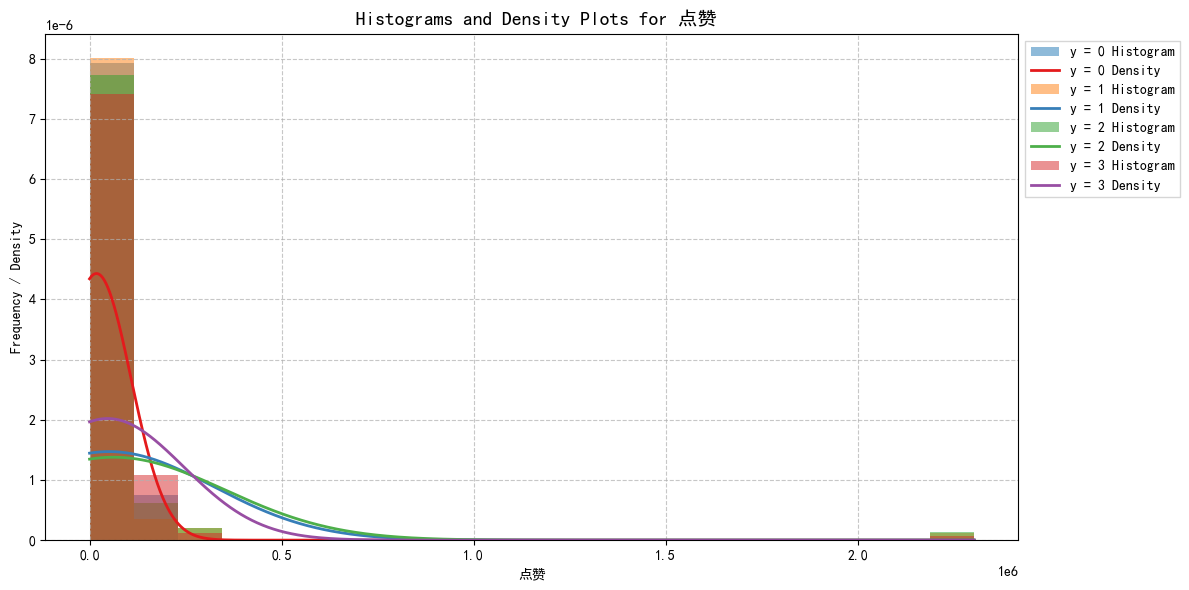

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 评论


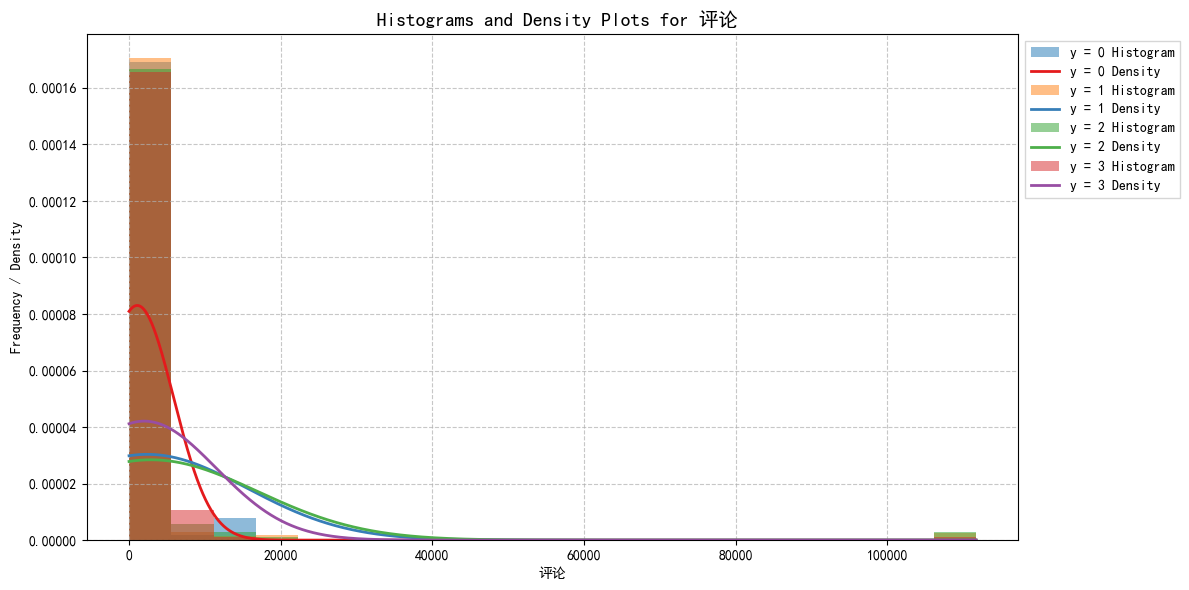

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 分享


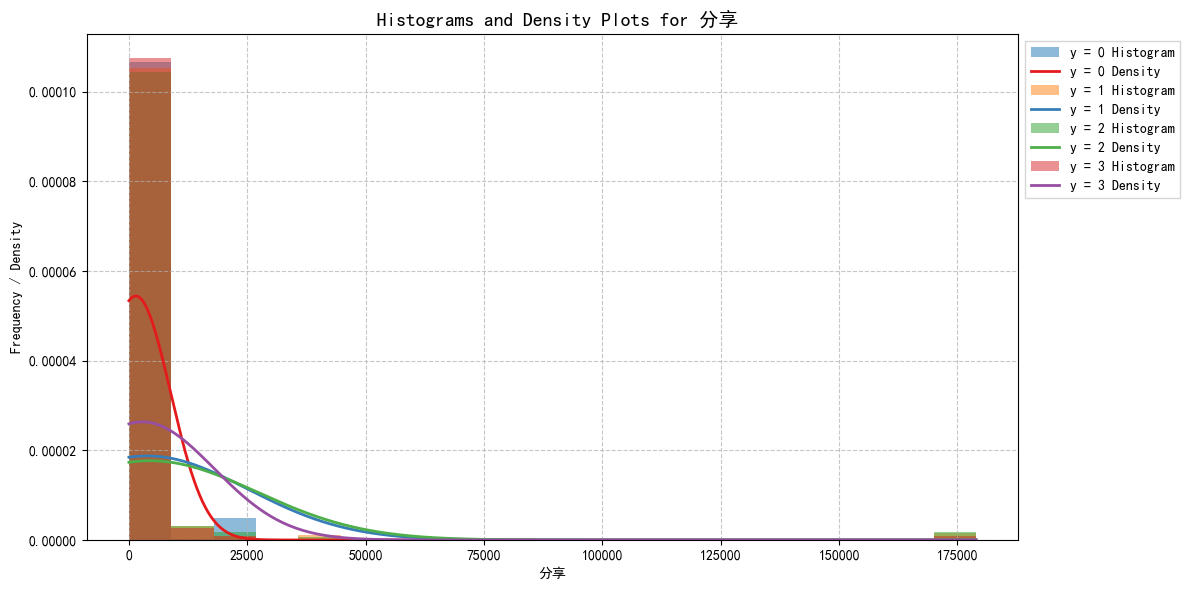

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 收藏


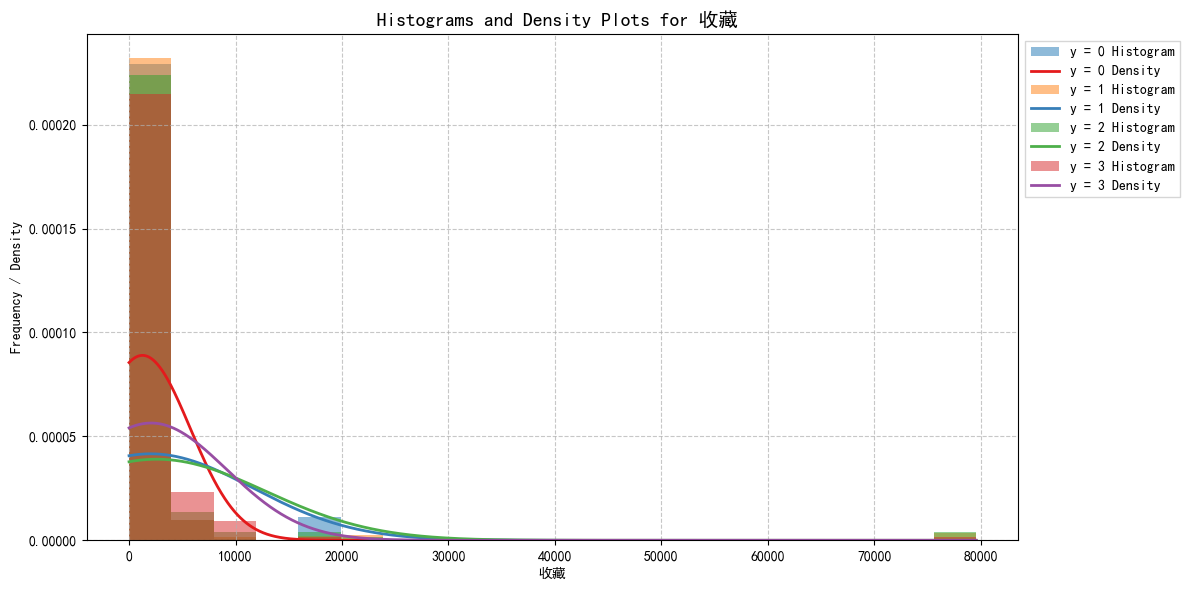

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 互动量


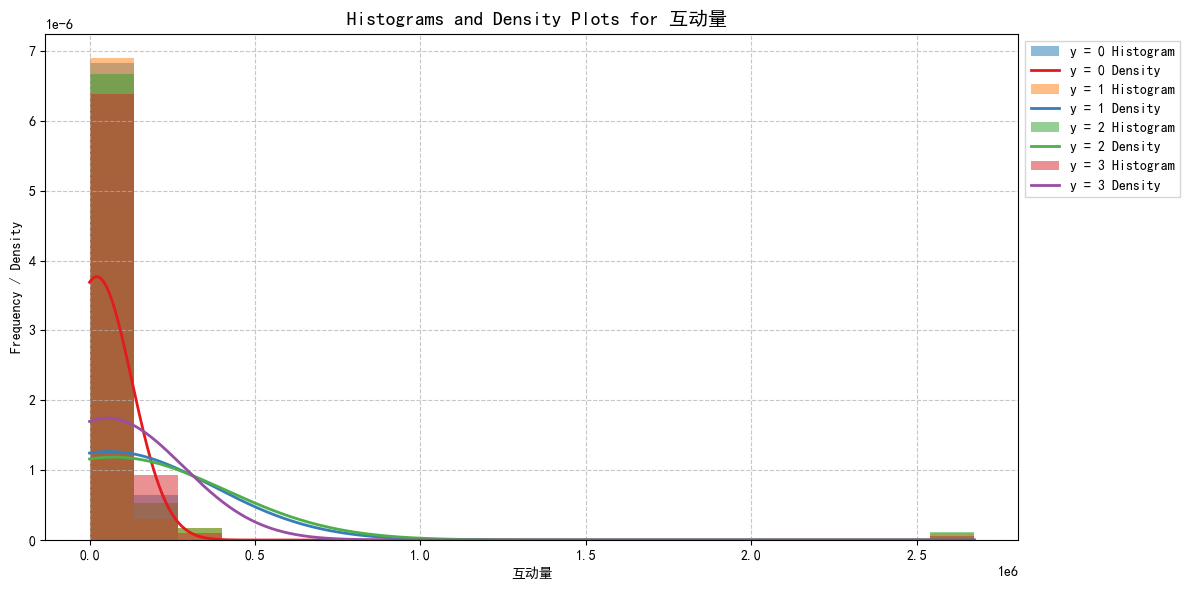

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 互动率


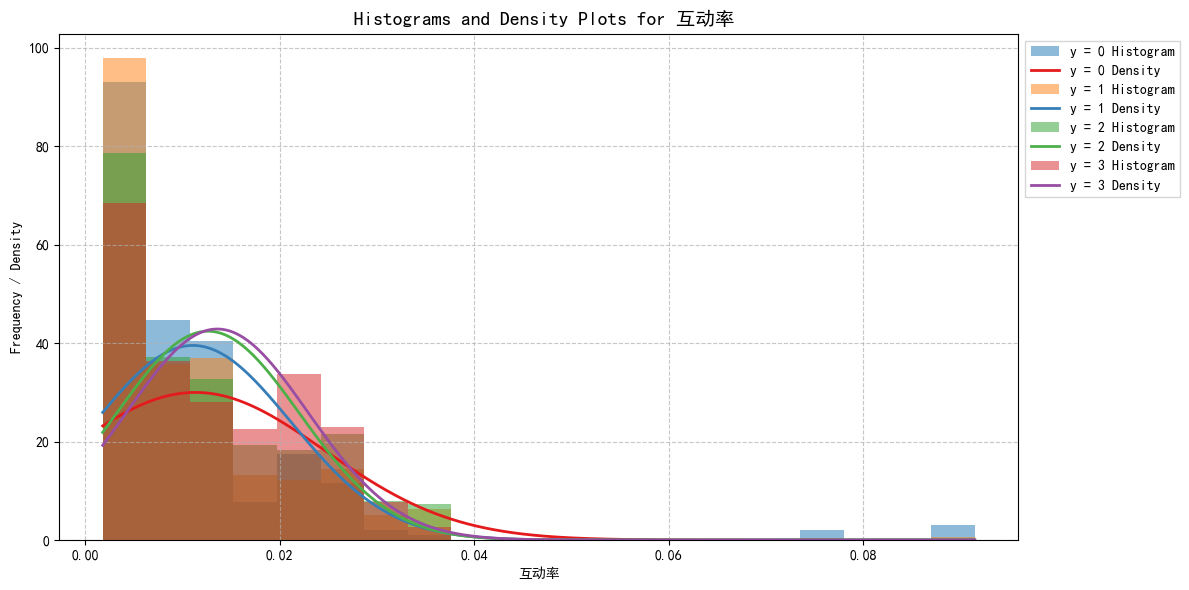

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for cluster_label


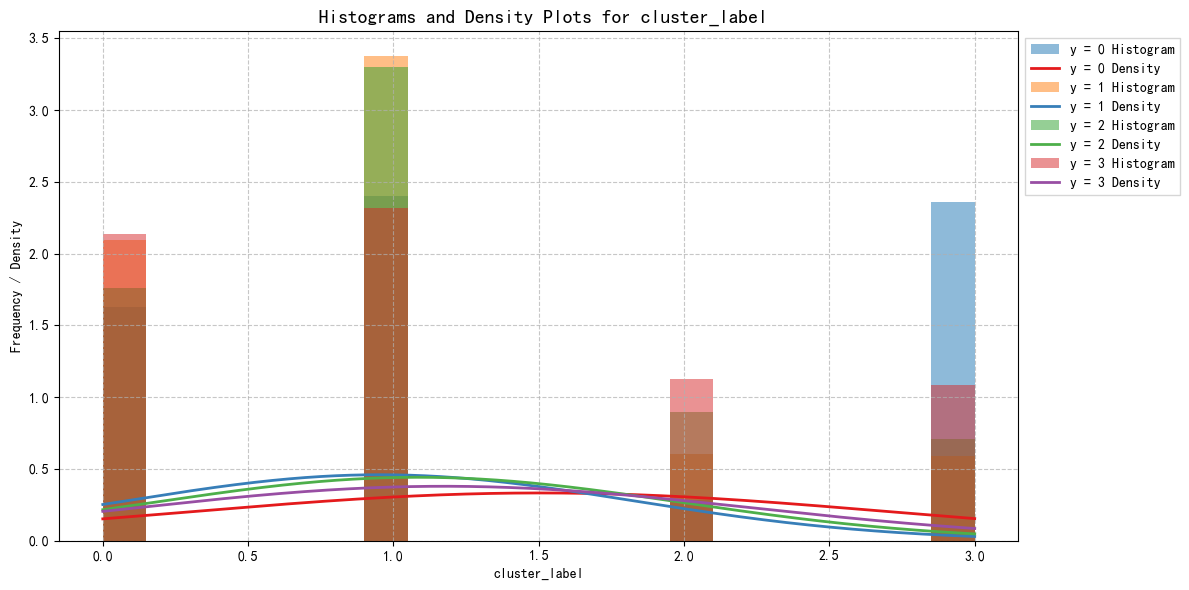

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 销售均价最大差值


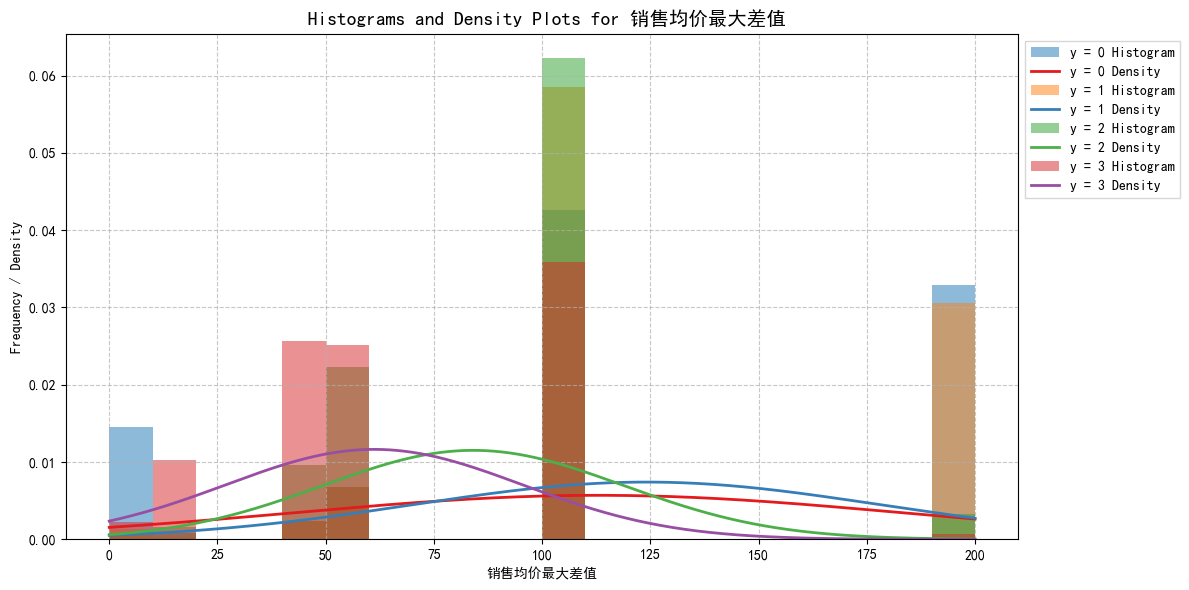

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 销售均价


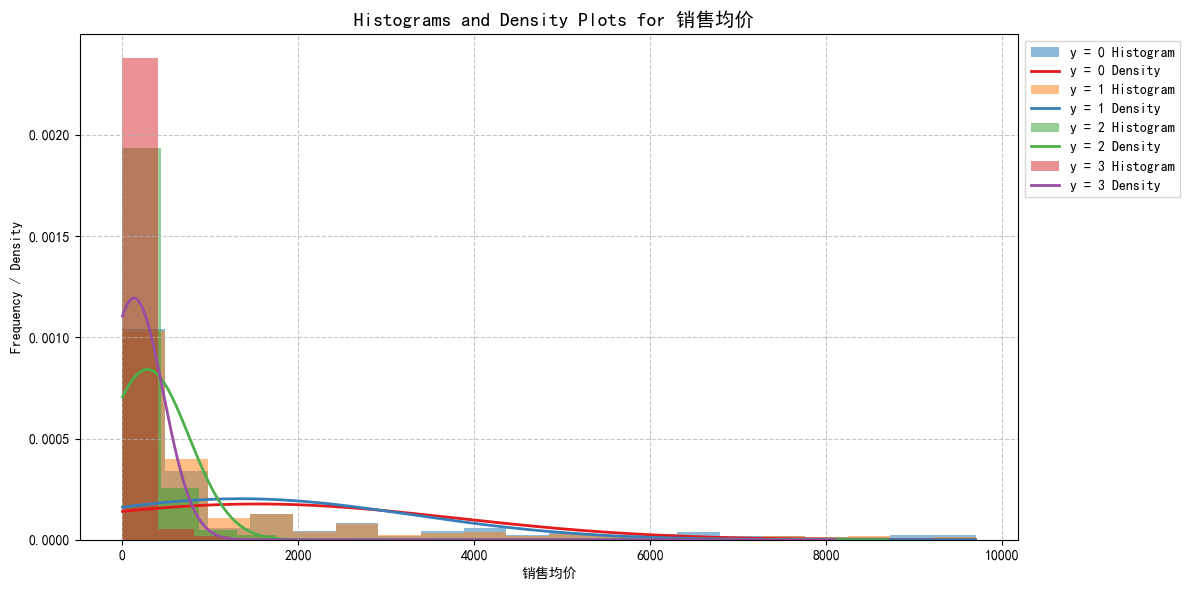

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 商品价格最大差值


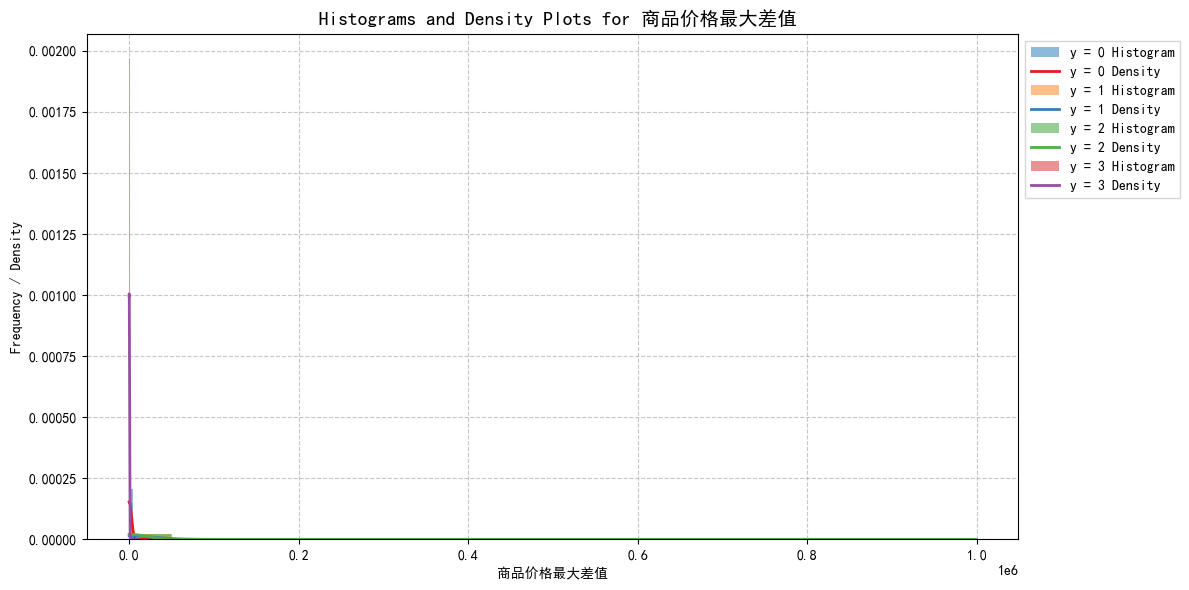

Correlation Matrix 图像已保存至 ../EDA/ Histograms and Density Plots for 商品价格中位数


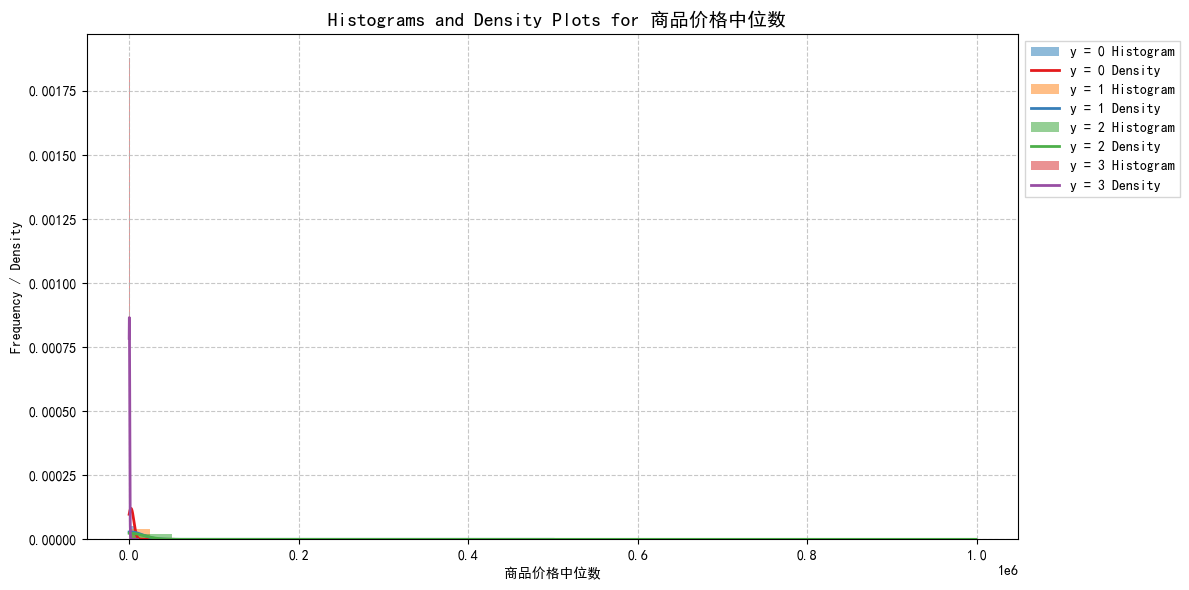

In [10]:
y_name = '转化率_1'
for target in X.columns:
    plot_distribution(df,target,y_name)


Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 佣金率


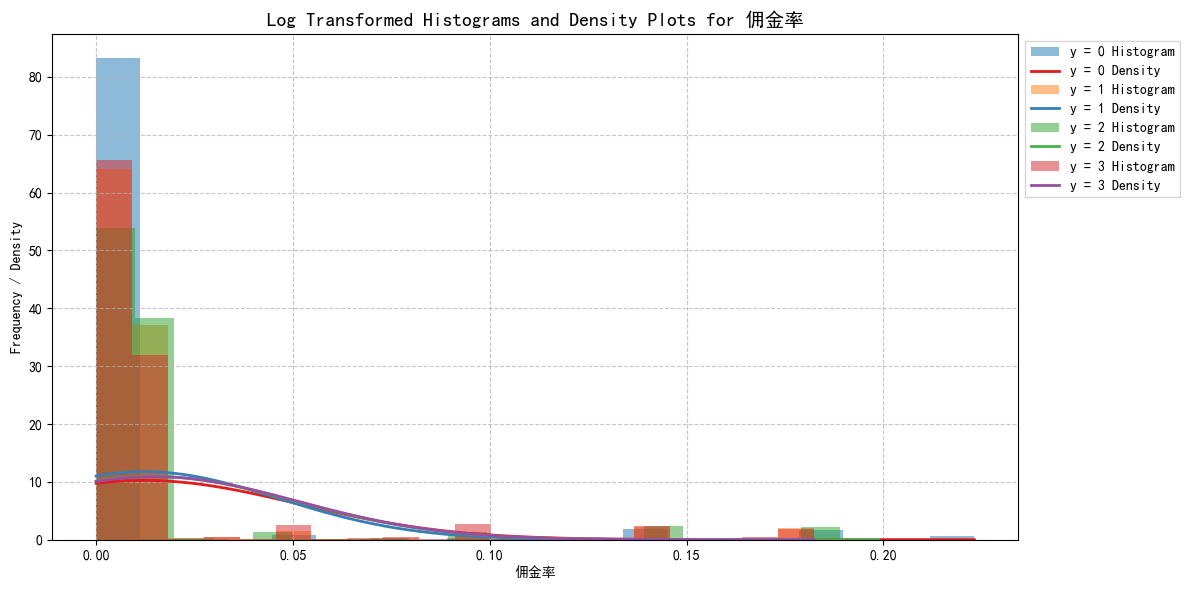

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 带货视频


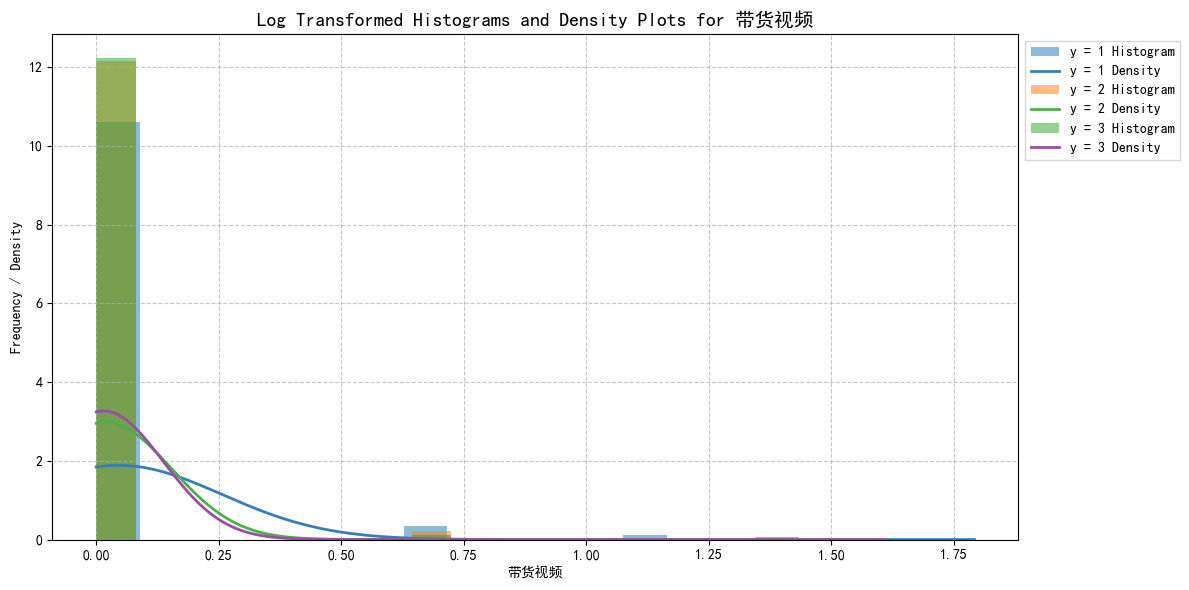

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 带货直播


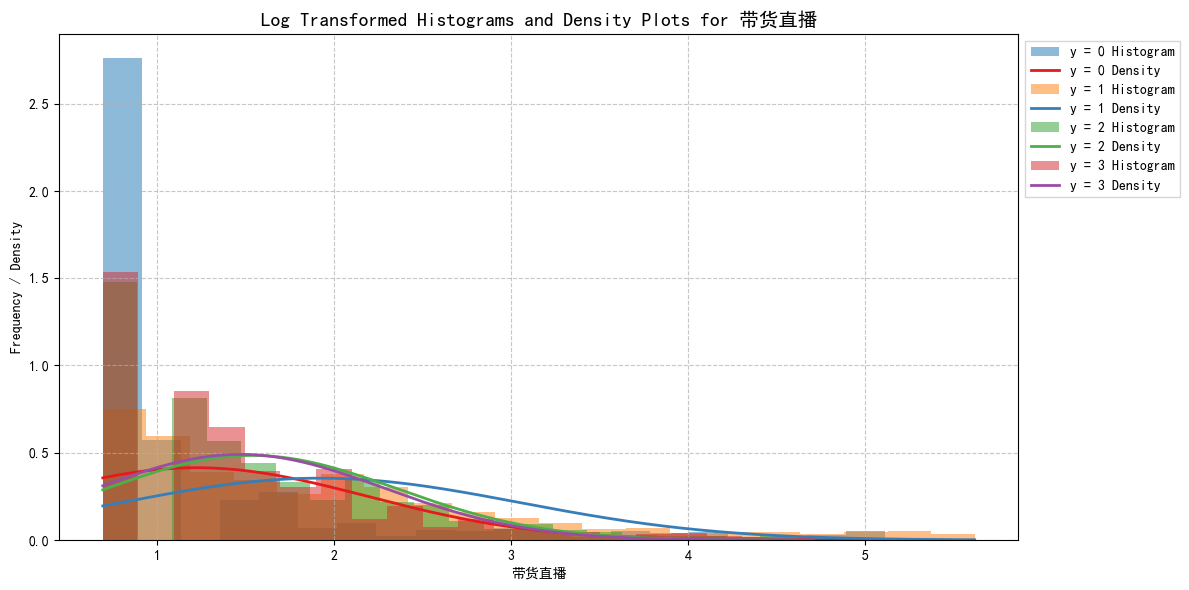

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 粉丝数


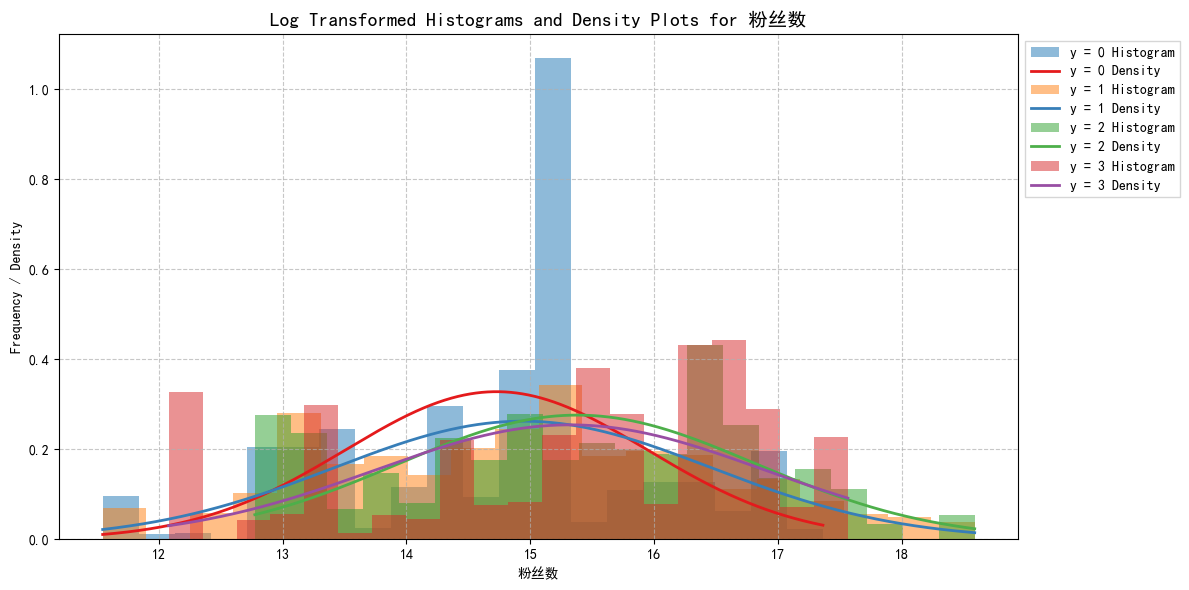

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 销售额_编码


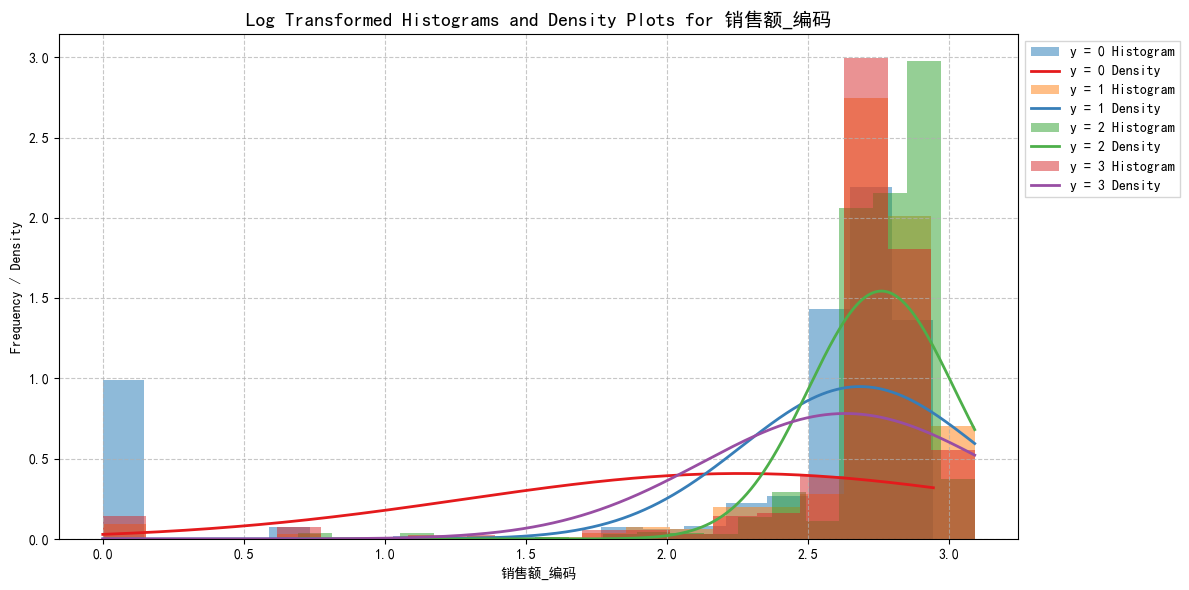

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 销量_编码


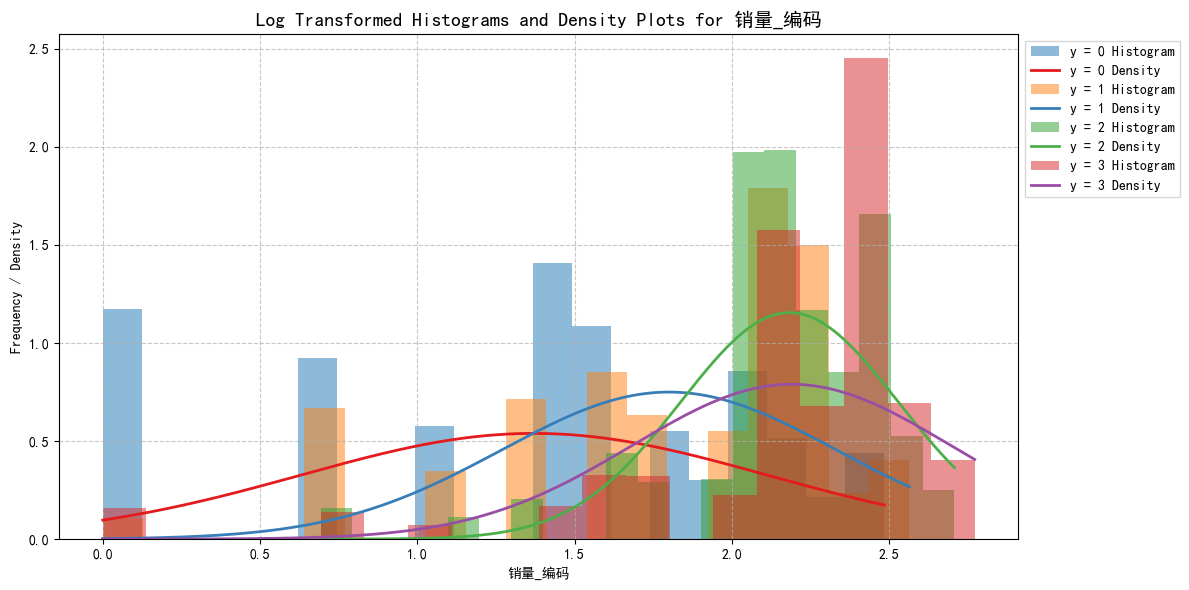

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 视频销售额_编码


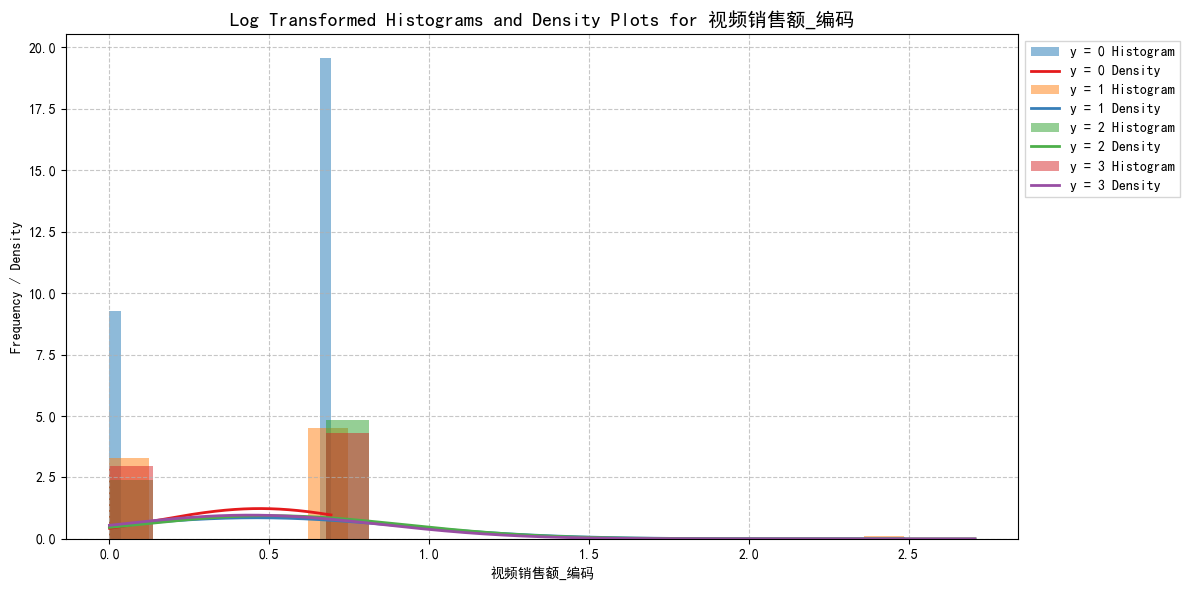

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 视频销量_编码


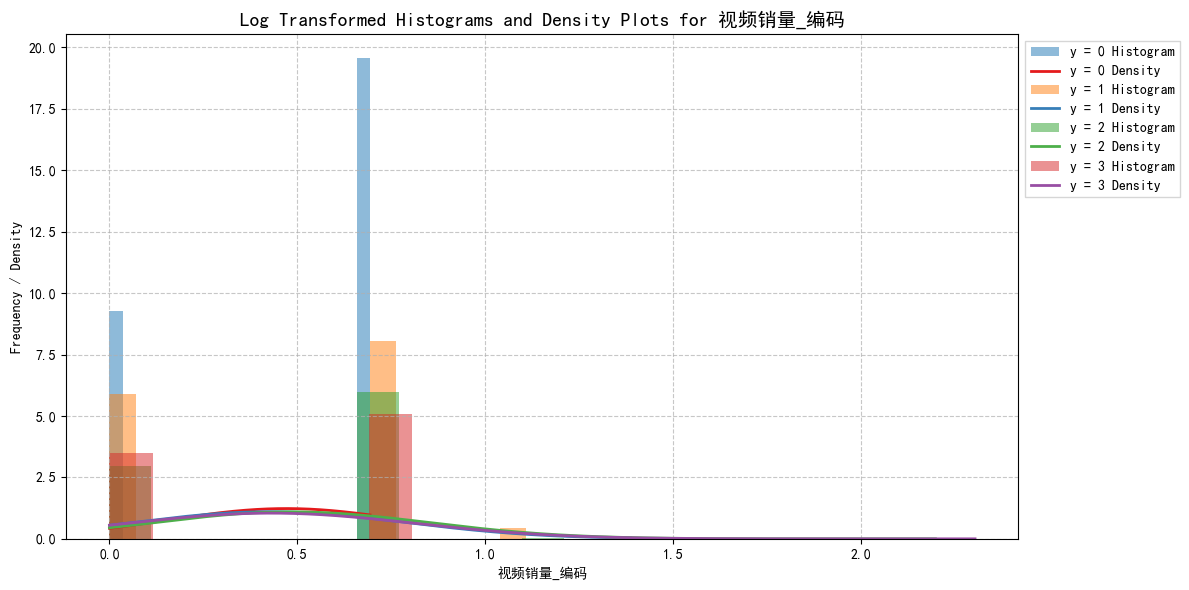

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 直播销售额_编码


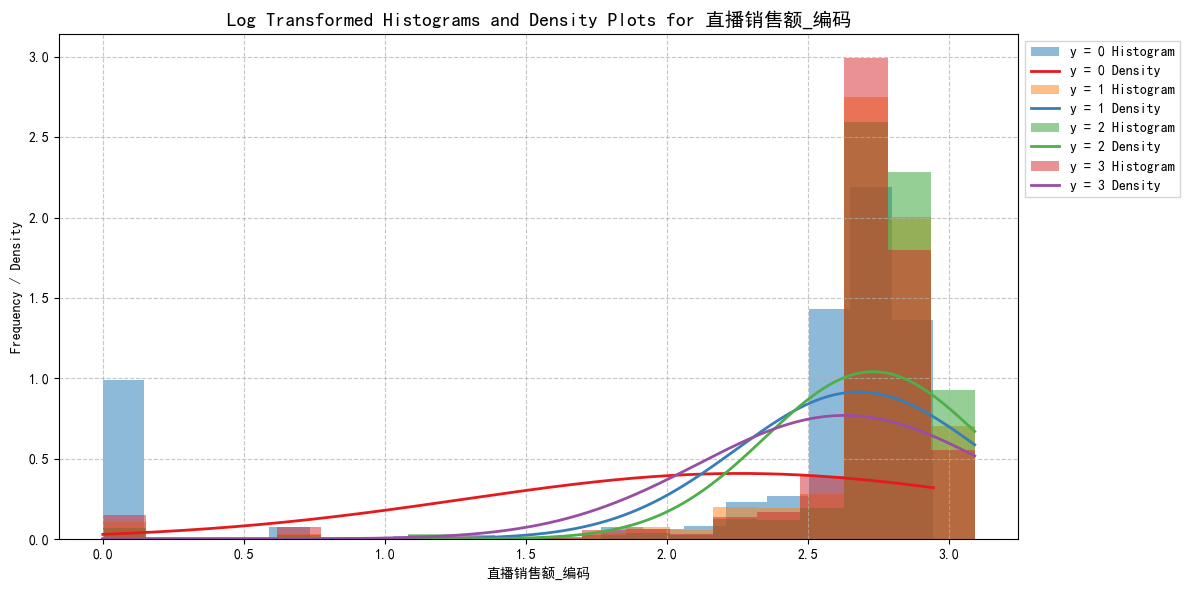

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 直播销量_编码


Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 上架距今(天)


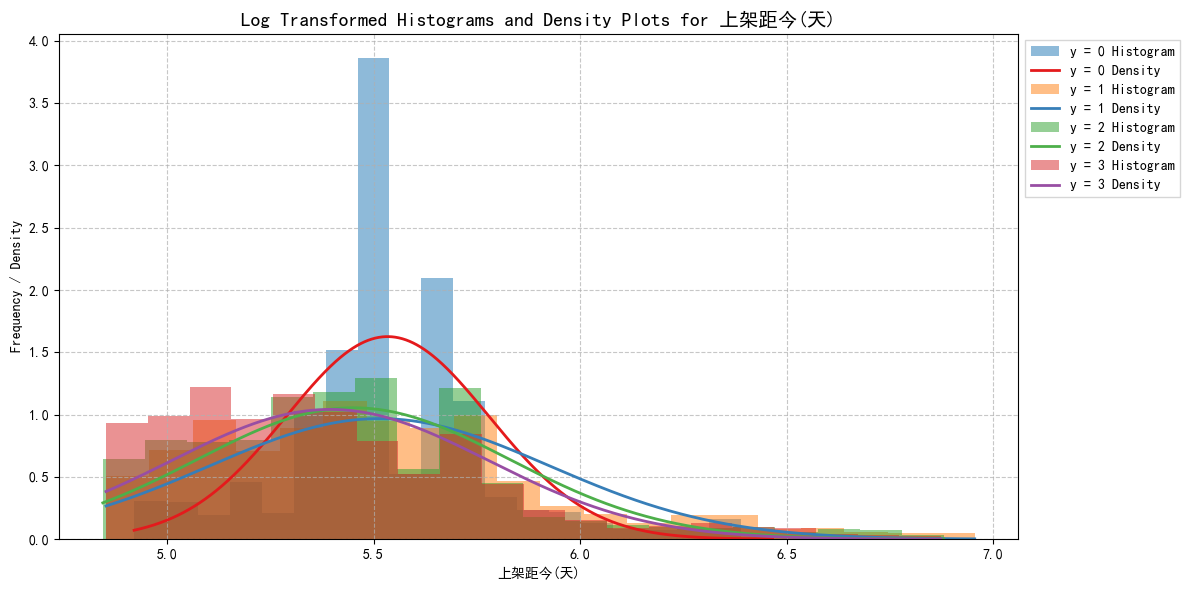

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 视频热度


Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 点赞


Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 评论


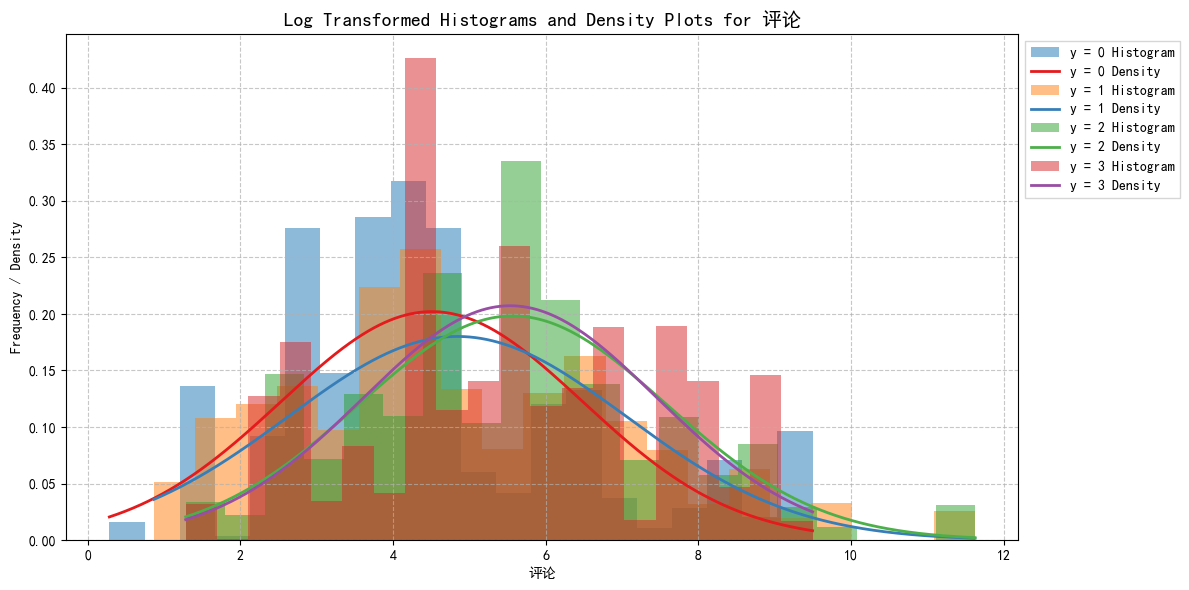

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 分享


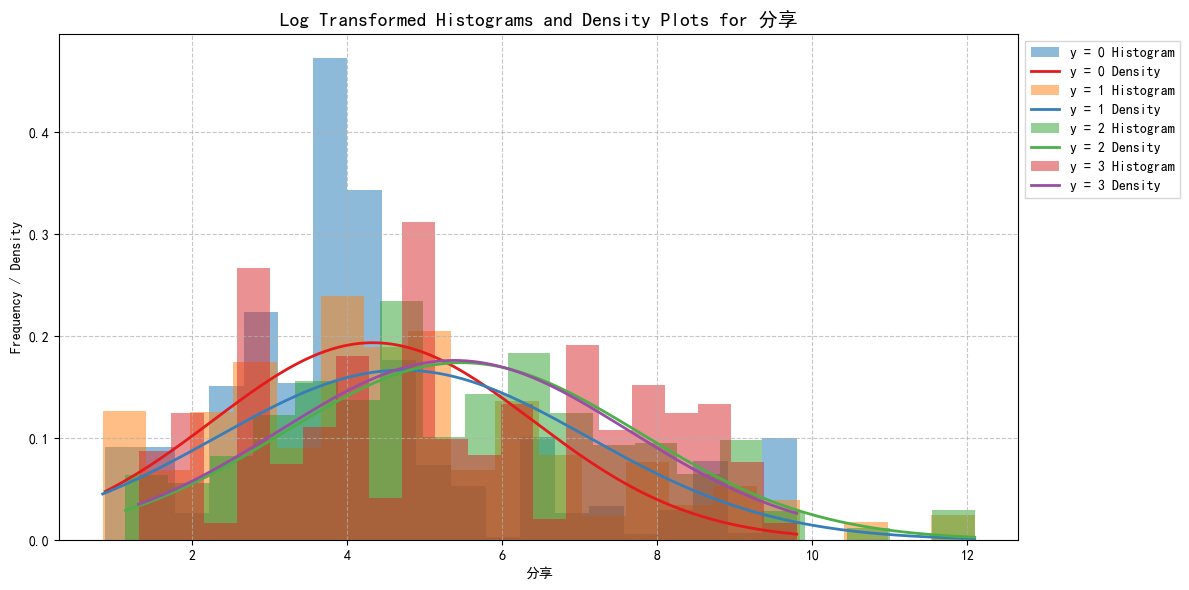

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 收藏


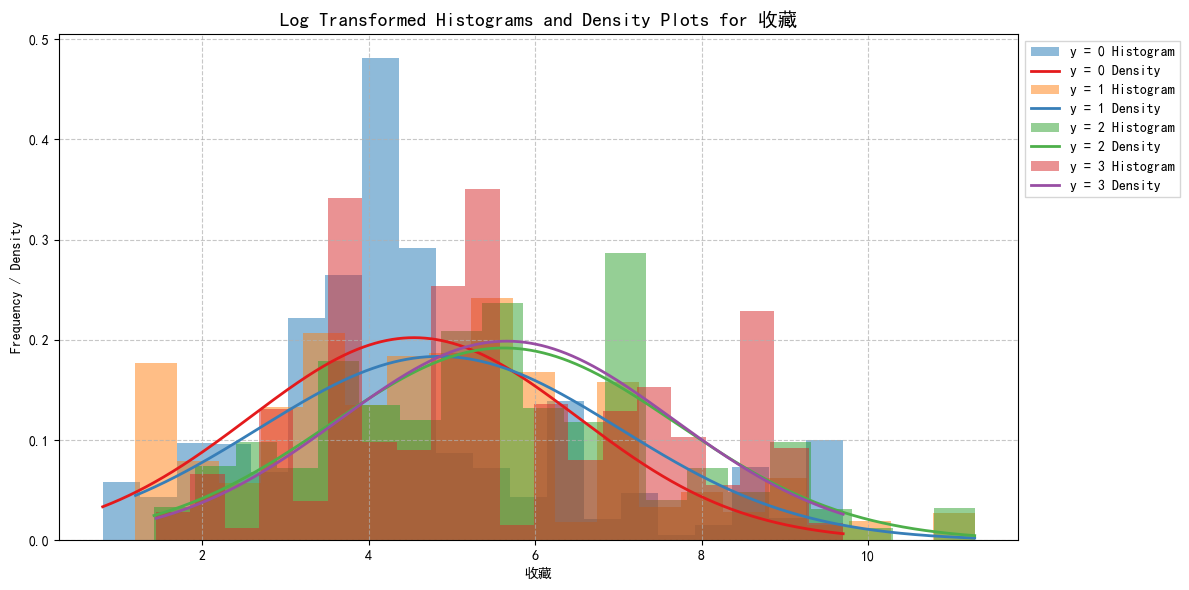

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 互动量


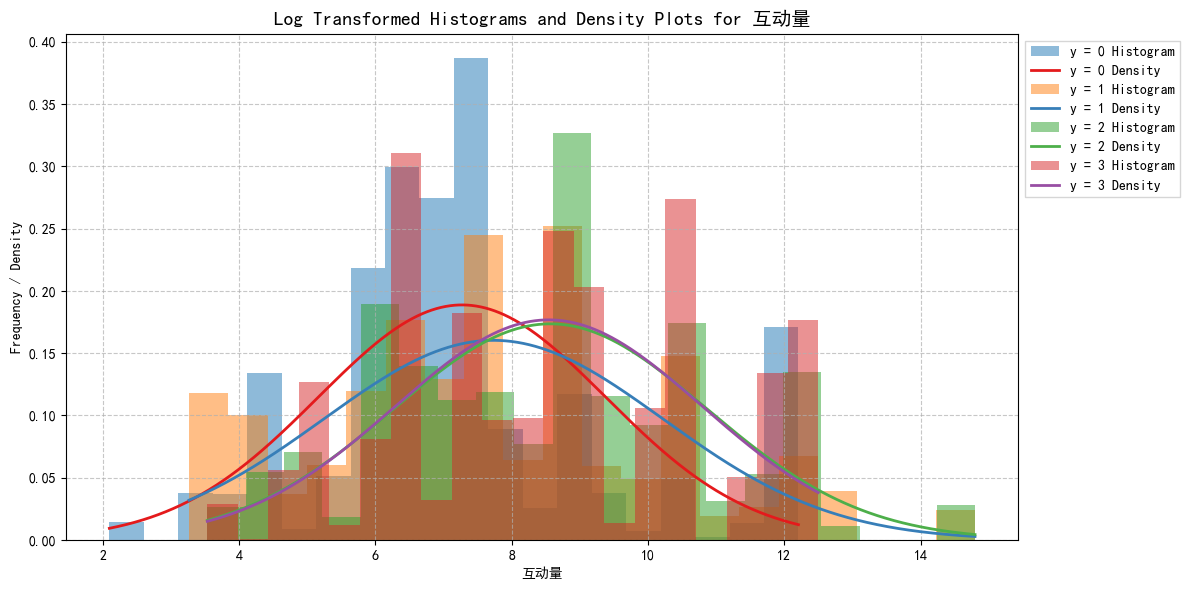

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 互动率


Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for cluster_label


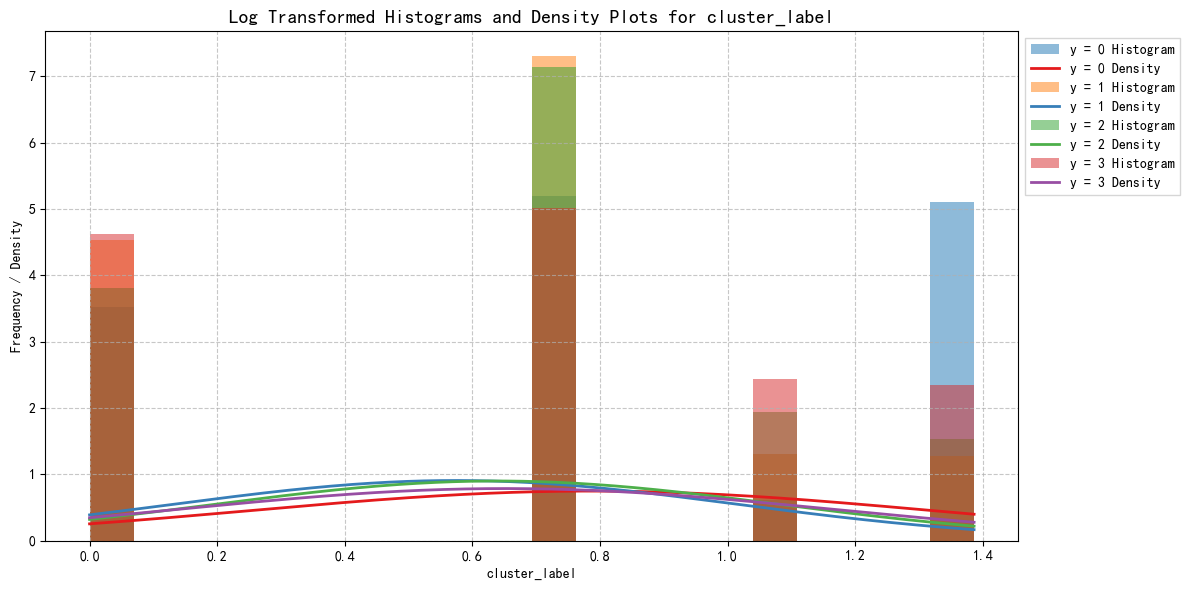

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 销售均价最大差值


Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 销售均价


Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 商品价格最大差值


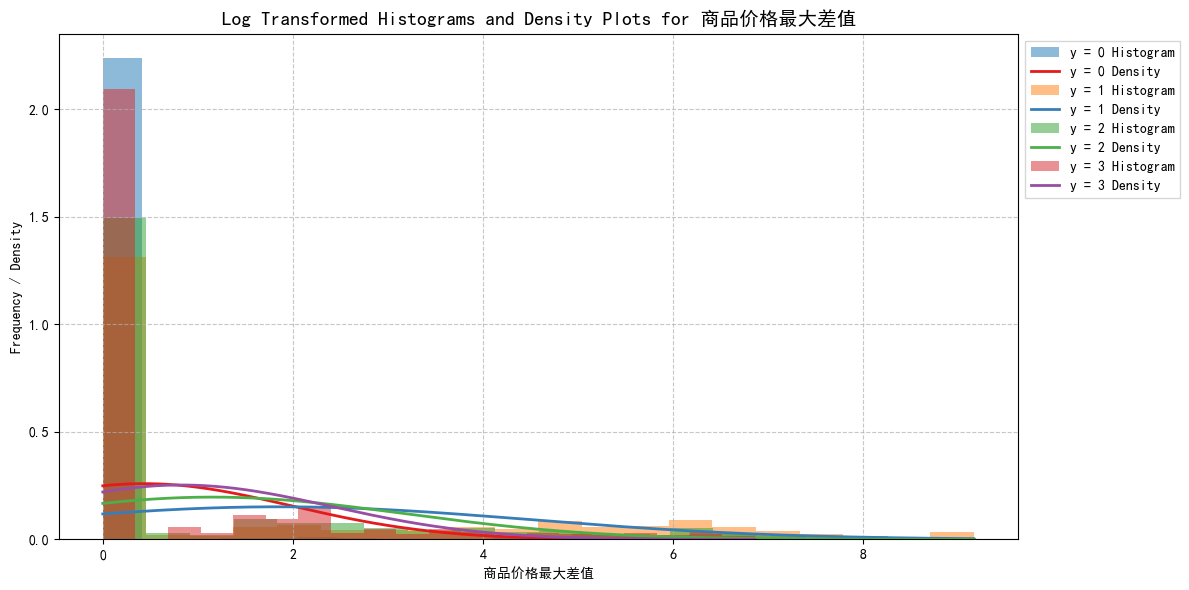

Correlation Matrix 图像已保存至 ../EDA/Log Transformed Histograms and Density Plots for 商品价格中位数


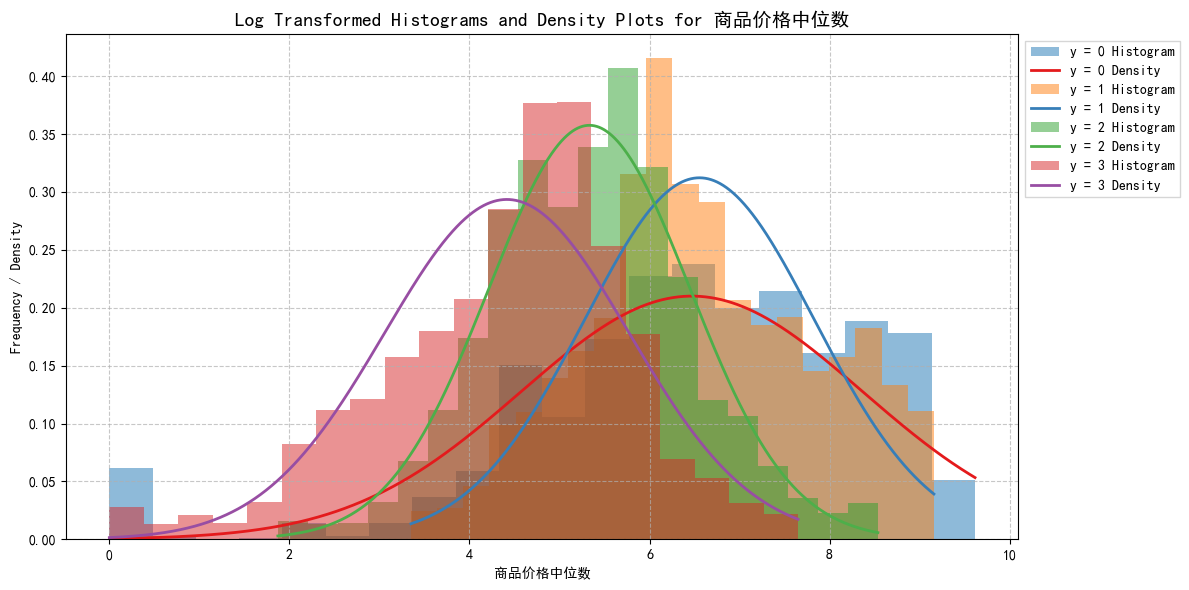

In [11]:
y_name = '转化率_1'
for target in X.columns:
    plot_distribution(df, target, y_name, log_transform=True, trim_outliers=True)


In [12]:
# y_name = '转化率_1'
# df_copy1 = df.copy()
# df_copy1['标准化差值'] = df_copy1['销售均价最大差值']/df_copy1['销售均价中位数']
# # for cluster in df_copy['cluster_label']
# # plot_distribution(df_copy1,'标准化差值', y_name, log_transform=True, trim_outliers=False)
# plot_distribution(df_copy1,'带货视频', y_name, log_transform=False, trim_outliers=True)

In [13]:
target = '转化率_1'
cont_cols=[f for f in df.columns if df[f].dtype  != 'O' and df[f].nunique()>2 and f not in [target]]

Correlation Matrix 图像已保存至 ../EDA/Feature_Distrubition


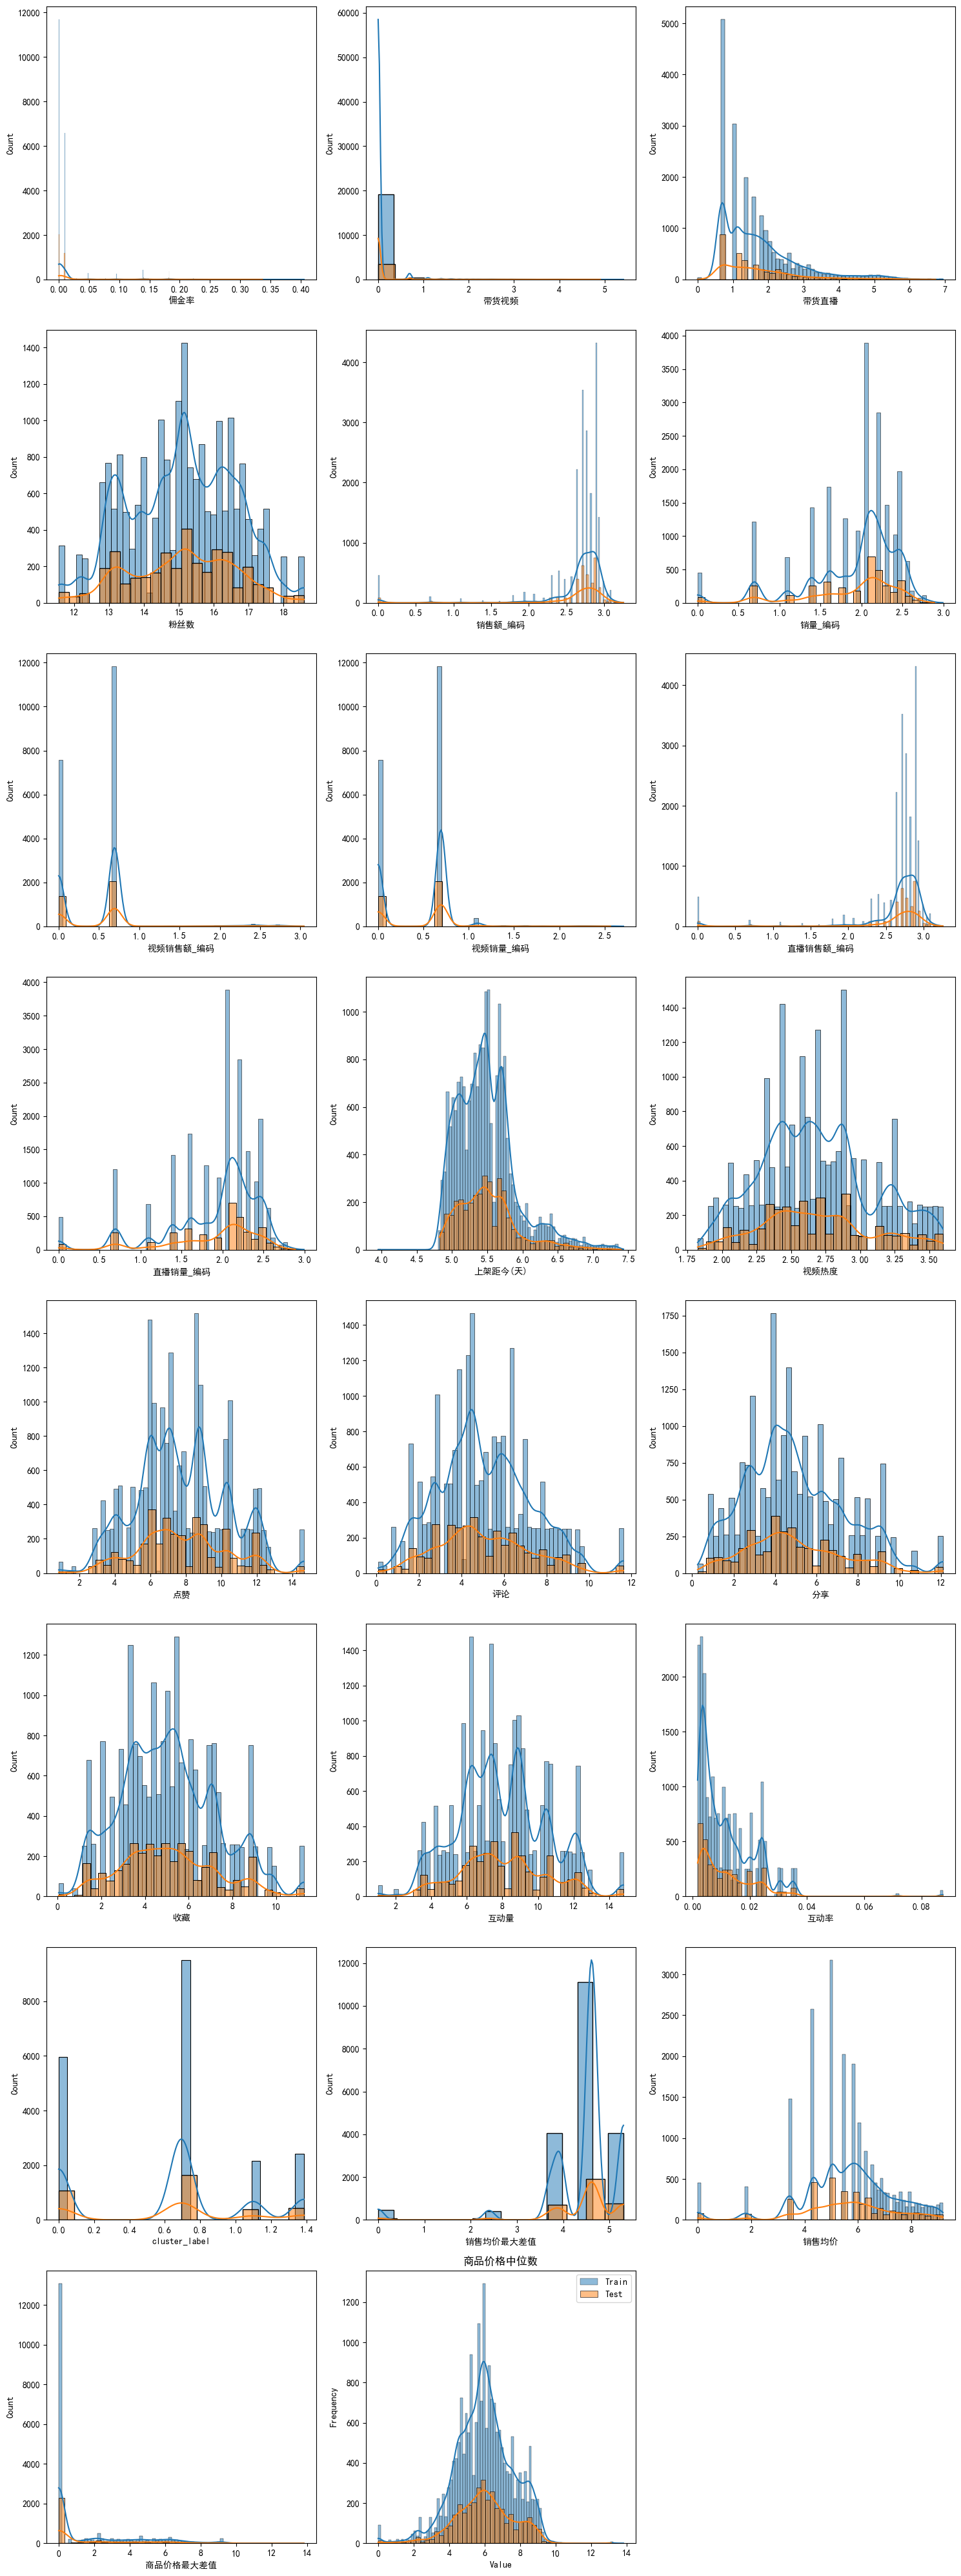

In [14]:
# cont_cols=[f for f in df.columns if df[f].dtype  != 'O' and df[f].nunique()>2 and f not in [target]]
num_rows = (len(cont_cols) + 2) // 3
fig = plt.figure(figsize=(15, num_rows*5))

for i, col in enumerate(cont_cols):
#     max_val = df[col].max()
#     min_val = df[col].min()
#     range_val = max_val - min_val
#     bin_size = range_val / 20
#     num_bins_train = num_bins_test =  round(range_val / bin_size)
    row = i // 3
    col_pos = i % 3
    plt.subplot(num_rows,3,i+1)
    sns.histplot(np.log1p(X_train[col]),  kde=True, label='Train')
    sns.histplot(np.log1p(X_test[col]), kde=True, label='Test')
    

save_path = f'../EDA/Feature_Distrubition'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Correlation Matrix 图像已保存至 {save_path}")
plt.title(col)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.gcf().set_facecolor
plt.tight_layout()
plt.show()

In [15]:
plt.figure(figsize=(12, 12))
sns.boxplot(data=X_train.apply(lambda x:np.log1p(x)), orient='h', palette='Set3')
plt.title('Boxplot of Numerical Features')
plt.gcf().set_facecolor('#FFF8DC')
plt.show()

## 散点图 

In [16]:
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
# cont_cols=[f for f in df.columns if df[f].dtype in [float,int] and df[f].nunique()>2 and f not in [target]]
num_rows = (len(cont_cols) + 2) // 3
fig = plt.figure(figsize=(15, num_rows*5))

for i, col in enumerate(cont_cols):
    row = i // 3
    col_pos = i % 3
    plt.subplot(num_rows,3,i+1)
    
    sns.scatterplot(data=df, x=col, y='转化率_1', hue='cluster_label', palette='Set1')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(title='')
    plt.gcf().set_facecolor('orange')  
    
plt.show()

## 拟合

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch

def plot_polynomial_fit(data, target, features, degree=1, remove_outliers=True,print_squared=False):
    """
    使用多项式回归拟合多个特征，并绘制结果。

    参数:
    - data: 数据集 (DataFrame)
    - target: 目标变量列名 (str)
    - features: 特征列名列表 (list of str)
    - degree: 多项式阶数 (int, 默认1)
    - remove_outliers: 是否移除异常值 (bool, 默认True)
    """
    # 提取特征和目标变量
    X = data[features].values.reshape(-1, len(features))  # 多个特征
    y = data[target].values

    # 移除异常值（基于目标变量）
    if remove_outliers:
        mean_y = np.mean(y)
        std_y = np.std(y)
        mask = (y >= mean_y - 3 * std_y) & (y <= mean_y + 3 * std_y)
        X = X[mask, :]  # 对二维数组 X 使用 mask
        y = y[mask]     # 对一维数组 y 使用 mask

    # 创建多项式特征
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)

    # 训练多项式回归模型
    model = LinearRegression()
    model.fit(X_poly, y)
    r_squared = model.score(X_poly, y)

    # 打印模型系数
    if print_squared:
        print(f"多项式回归系数 （col = {features}）(degree={degree}):")
        for i, coef in enumerate(model.coef_):
            print(f"  特征 {i}: {coef:.4f}")
        print(f"  截距: {model.intercept_:.4f}")
        print(f"  R²: {r_squared:.4f}")

    # 绘制拟合结果（仅适用于单特征或双特征a）
    if len(features) == 1:
        # 单特征：绘制二维曲线
        sns.scatterplot(x=X.flatten(), y=y, label='Data', color='blue')
        X_fit = np.linspace(X.min(), X.max(), 20000).reshape(-1, 1)
        X_fit_poly = poly.transform(X_fit)
        y_fit = model.predict(X_fit_poly)
        plt.plot(X_fit, y_fit, color='red', label=f'Polynomial Fit (degree={degree})')
        plt.title(f'Polynomial Fit for {features[0]} vs {target} (R²={r_squared:.3f})')
        plt.xlabel(features[0])
        plt.ylabel(target)
        plt.legend()
    elif len(features) == 2:
        # 双特征：绘制三维曲面
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X[:, 0], X[:, 1], y, label='Data', color='blue')
        
        # 生成网格数据
        x0_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 20)
        x1_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 20)
        x0_mesh, x1_mesh = np.meshgrid(x0_range, x1_range)
        X_mesh = np.c_[x0_mesh.ravel(), x1_mesh.ravel()]
        X_mesh_poly = poly.transform(X_mesh)
        y_mesh = model.predict(X_mesh_poly).reshape(x0_mesh.shape)
        
        surface = ax.plot_surface(x0_mesh, x1_mesh, y_mesh, color='red', alpha=0.5, label='Polynomial Fit')
        ax.set_xlabel(features[0])
        ax.set_ylabel(features[1])
        ax.set_zlabel(target)
        plt.title(f'Polynomial Fit for {features} vs {target} (R²={r_squared:.3f})')

        # 使用代理艺术家创建图例
        proxy = Patch(color='red', alpha=0.5, label='Polynomial Fit')
        ax.legend(handles=[proxy])

# data = df
data = df_scaled[~df_scaled['转化率_1'].isna()]

Feature_Fitting 图像已保存至 ../EDA/Feature_Fitting


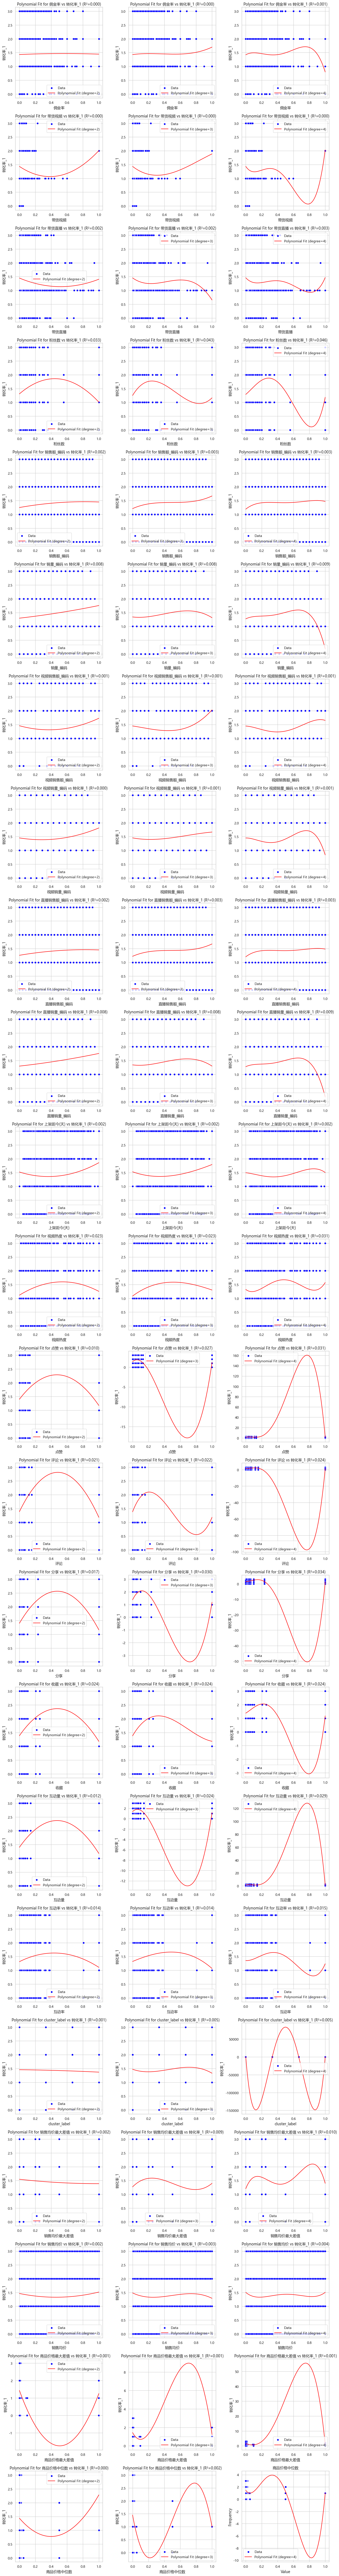

In [18]:
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
# cont_cols=X_train.columns
# num_rows = (len(cont_cols) + 2) // 3
num_rows = (len(cont_cols) + 2) 
fig = plt.figure(figsize=(15, num_rows*5))

for i,col in enumerate(cont_cols):
    for j in range(1,4):
        plt.subplot(num_rows,3,3*i+j)
        plot_polynomial_fit(data, '转化率_1', [col], degree=j+1, remove_outliers=True,print_squared=False)
        
plt.title(col)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()

save_path = f'../EDA/Feature_Fitting'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Feature_Fitting 图像已保存至 {save_path}")

plt.show()

多项式回归系数 （col = ['销售均价', 'cluster_label']）(degree=3):
  特征 0: -1.0017
  特征 1: -0.8896
  特征 2: 2.8629
  特征 3: -1.1186
  特征 4: 3.0899
  特征 5: -2.0034
  特征 6: 0.0948
  特征 7: 1.0165
  特征 8: -2.3206
  截距: 1.5004
  R²: 0.0078


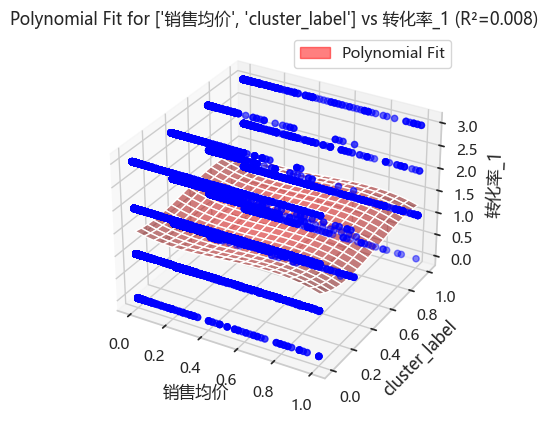

In [19]:
plot_polynomial_fit(data, '转化率_1', ['销售均价','cluster_label'], degree=3, remove_outliers=False,print_squared=True)